# **Import Libraries and Dataset**

In [1]:
# Install UCI ML Repo(Run only the first time)
!pip install xgboost
!pip install tensorflow
!pip install keras-tuner
!pip install seaborn

### **Import Dataset**

In [2]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

In [3]:
# Import Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data Preprocessing Modules
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

# Import Fine tuning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV, GridSearchCV


# Import Evaluation Metrics
from sklearn import metrics
from scipy.stats import randint
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix
from keras_tuner import RandomSearch, HyperParameters

# Import Models
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import tensorflow as tf

In [4]:
# Detect TPU
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU

# print("REPLICAS: ", strategy.num_replicas_in_sync)

In [5]:
# Importing data from the UCI archives
adult = fetch_ucirepo(id=2)
df = pd.DataFrame(data=adult.data.original, columns=adult.feature_names)
print(df.shape)
df.head()

(48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# **Data Discovery**

In [6]:
# Summary statistics for numerical columns
print(df.describe())

# Information about the dataset, including data types and missing values
print(df.info())

                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    48842.000000  
mean        40.422382  
std         12.391444  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries

### **Encode Target Variable**

In [7]:
df.groupby('income').size()

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
dtype: int64

In [8]:
# Encode target feature as 0(<=50K) and 1(>50K)
df['income'] = df['income'].str.strip().map({'<=50K': 0, '<=50K.': 0, '>50K': 1, '>50K.': 1})
df['income'] = df['income'].astype(int)
df.groupby('income').size()

income
0    37155
1    11687
dtype: int64

### **Heatmap**

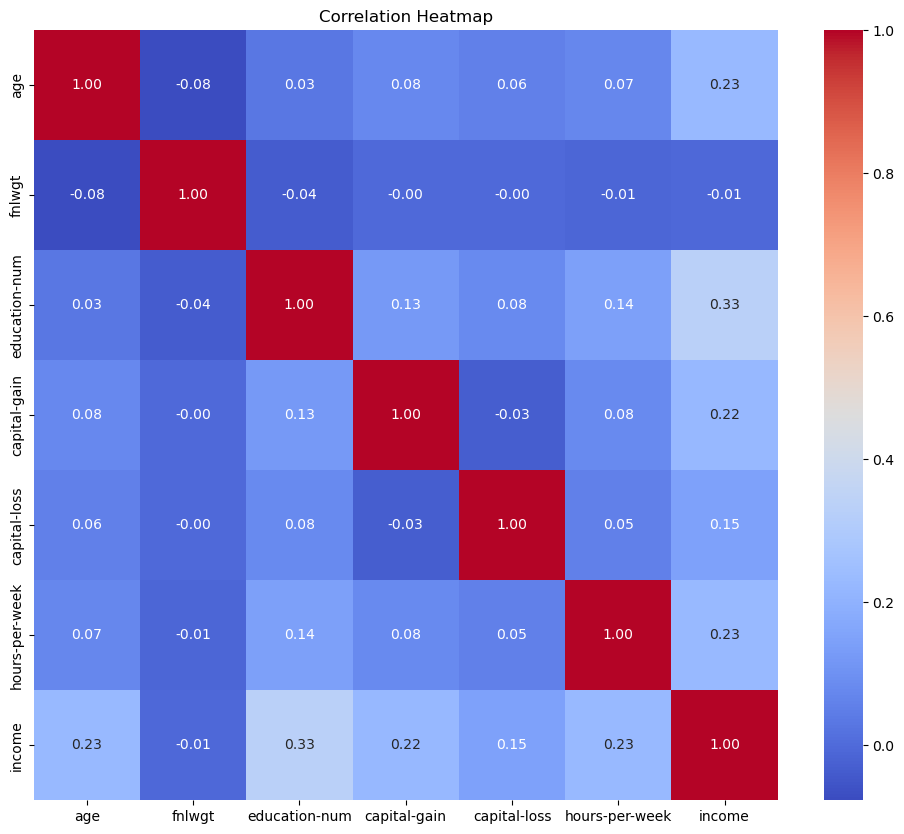

In [9]:
# Calculate the correlation matrix
correlation_matrix = df.corr(numeric_only=True)

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### **Data Visualization**

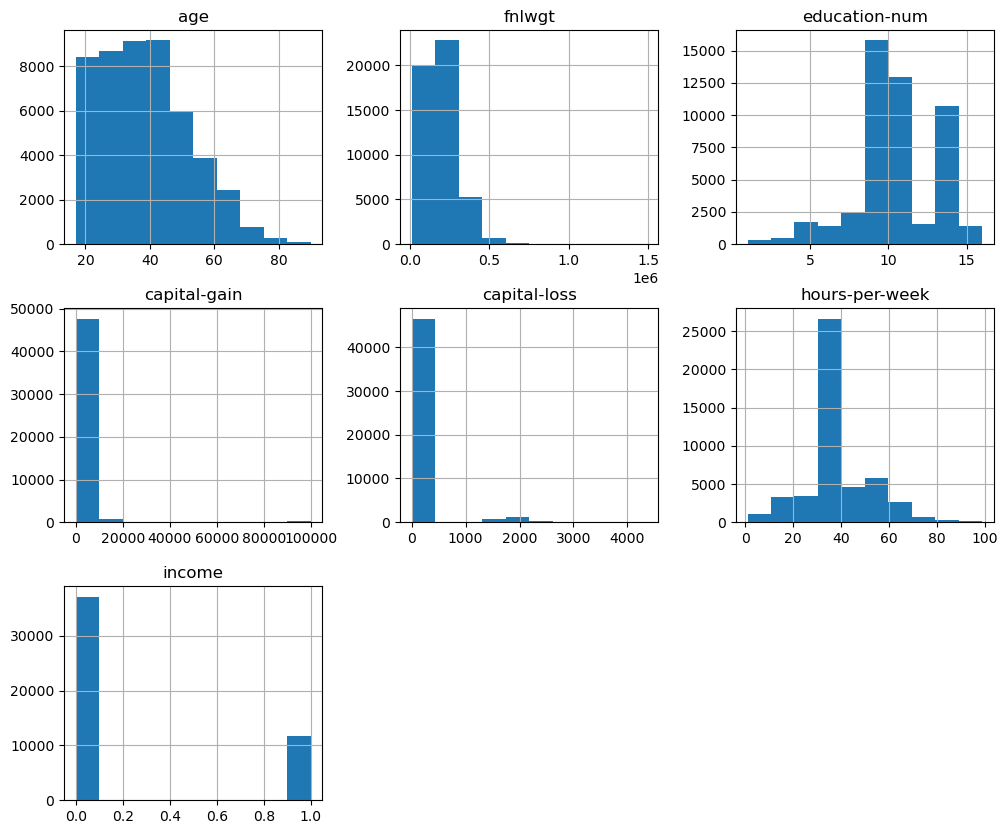

In [10]:
# Histograms of numerical features
df.hist(figsize=(12, 10))
plt.show()

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


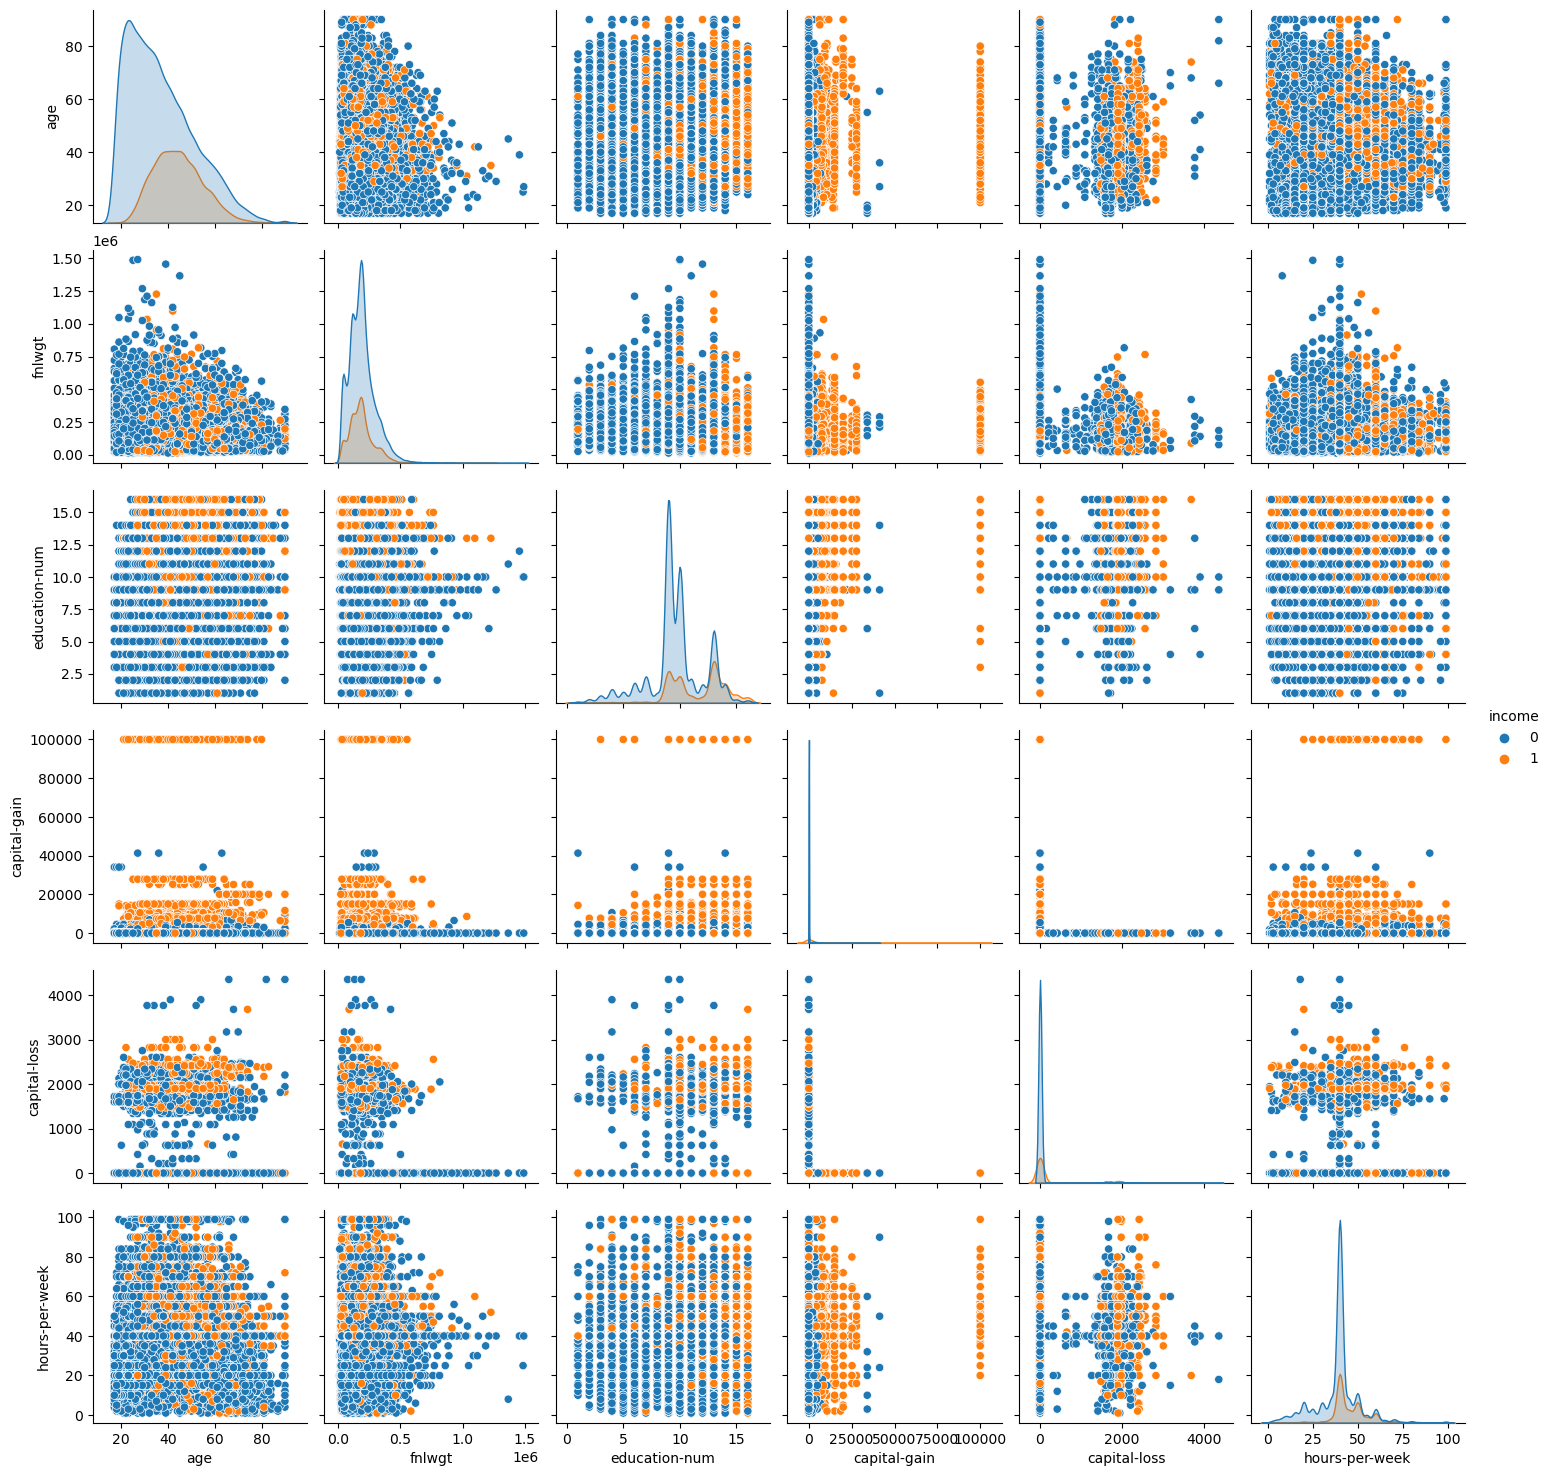

In [11]:
# Pairplot to visualize relationships between numerical features
sns.pairplot(df, hue='income', diag_kind="kde")
plt.show()

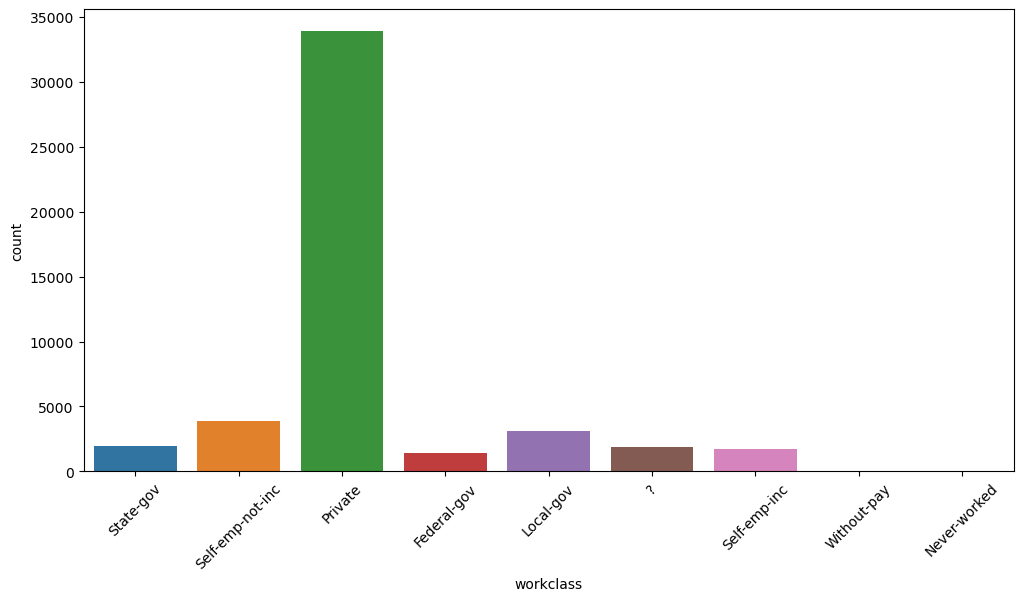

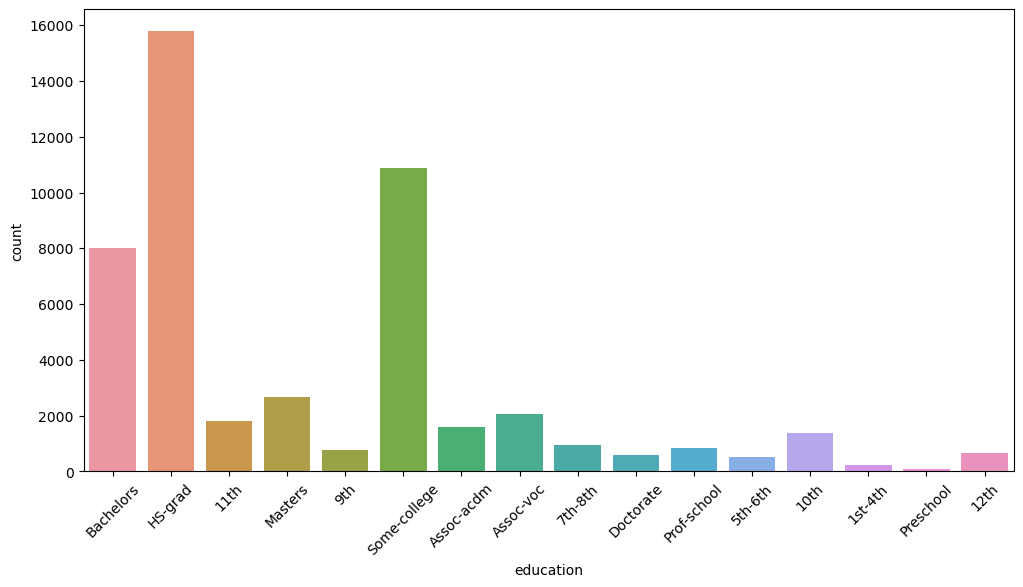

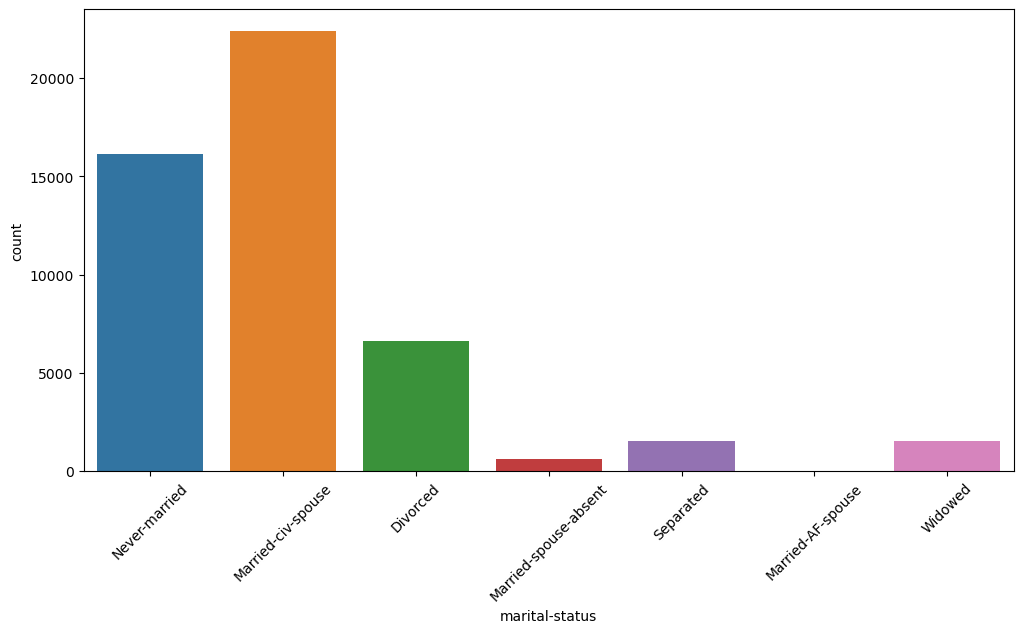

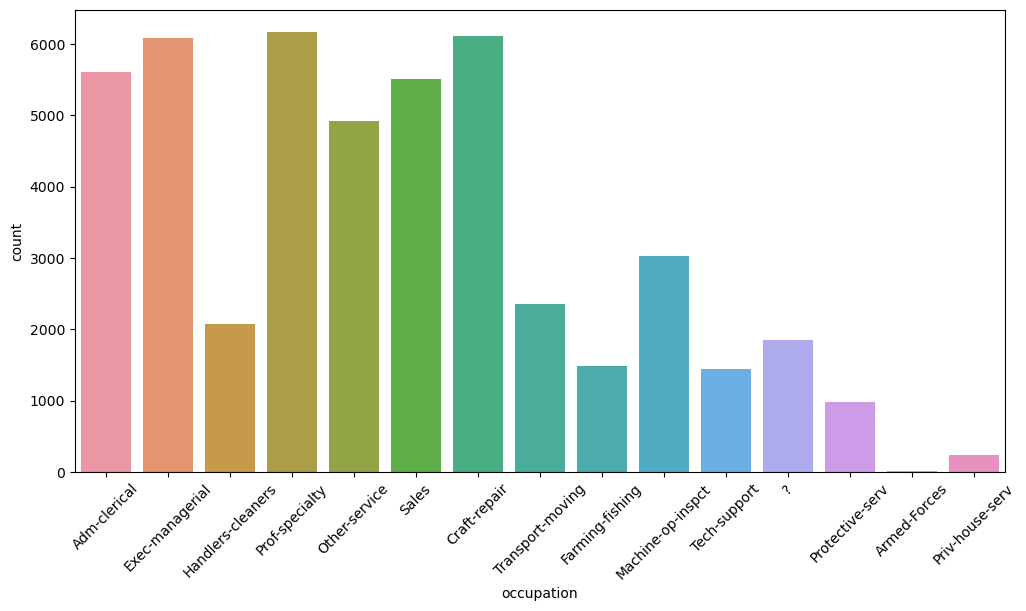

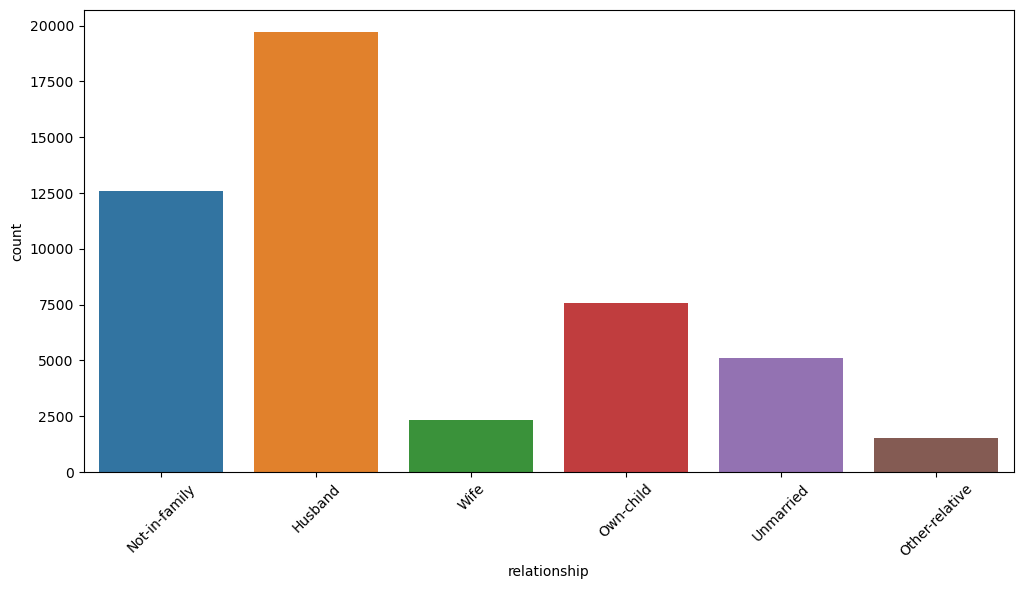

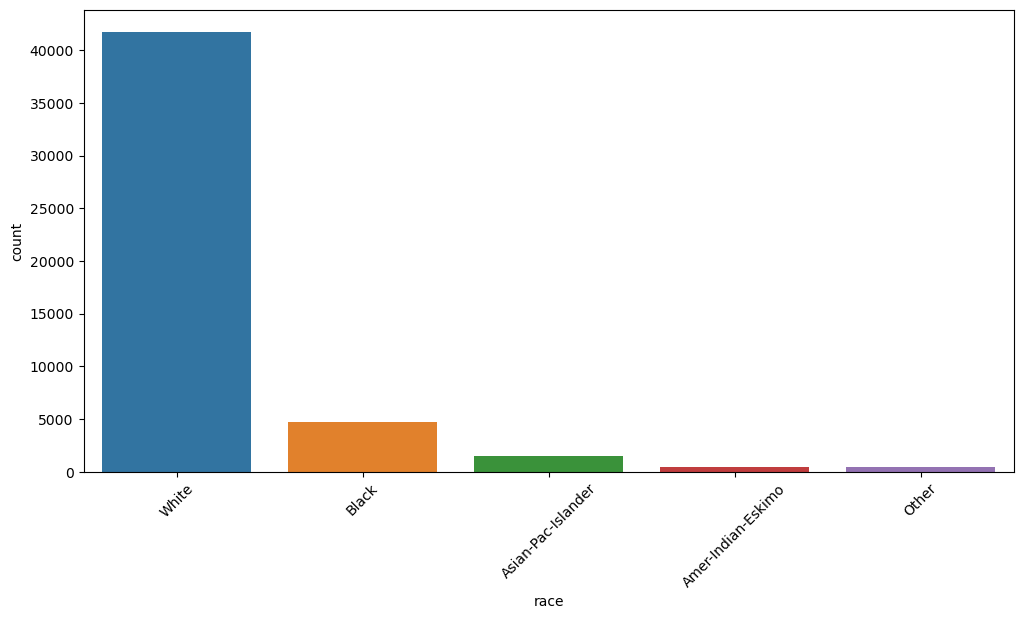

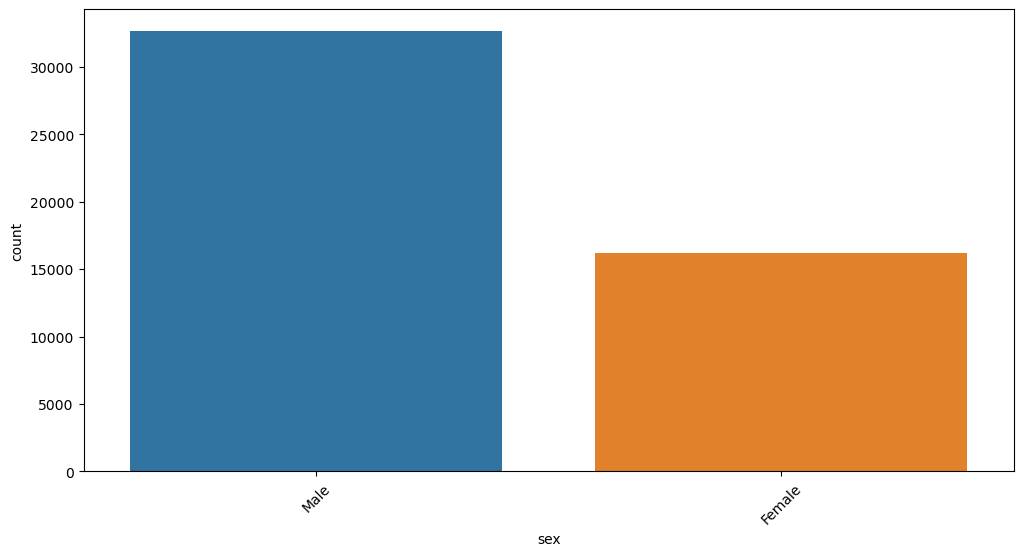

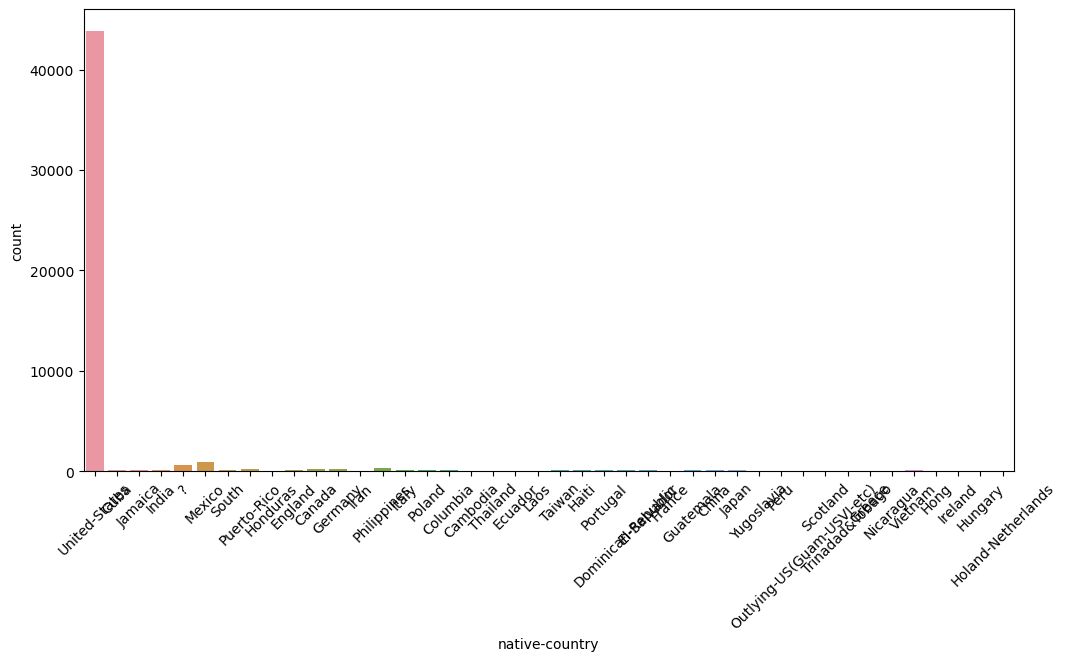

In [12]:
# Countplot for categorical features
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=column)
    plt.xticks(rotation=45)
    plt.show()

### **Dealing With Missing Values**

In [13]:
# Check for missing values
missing_data = df.isnull().sum()
print(missing_data)

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64


In [14]:
#finding special characters
df.isin(['?']).sum(axis=0)

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [15]:
# code will replace the special character to nan and then drop the columns
df['native-country'] = df['native-country'].replace('?',np.nan)
df['workclass'] = df['workclass'].replace('?',np.nan)
df['occupation'] = df['occupation'].replace('?',np.nan)

In [16]:
# Replace Missing Values with appropriate values
df['workclass'].fillna(df['workclass'].mode()[0], inplace=True)
df['native-country'].fillna(df['native-country'].mode()[0], inplace=True)
df['occupation'].fillna("Other", inplace=True)

In [17]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

### **Deal With Duplicates Values**

In [18]:
# Find duplicate records
df.loc[df.duplicated() == True]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
4881,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,0
5104,90,Private,52386,Some-college,10,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,35,United-States,0
9171,21,Private,250051,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,10,United-States,0
11631,20,Private,107658,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,10,United-States,0
13084,25,Private,195994,1st-4th,2,Never-married,Priv-house-serv,Not-in-family,White,Female,0,0,40,Guatemala,0
15059,21,Private,243368,Preschool,1,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,50,Mexico,0
17040,46,Private,173243,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
18555,30,Private,144593,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0
18698,19,Private,97261,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,0
21318,19,Private,138153,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,0


In [19]:
# The number of duplicates is insignificant so we can drop them.
df = df.drop_duplicates()
df.loc[df.duplicated() == True]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income


# **Feature Engineering and Selection**

### **Initailize Preprocessing**

In [20]:
# Initialize LabelEncoder
le = LabelEncoder()

# Initialize StandardScaler
std = StandardScaler()

# Initialize MinMaxScaler
mms = MinMaxScaler()

In [21]:
# Make a copy to preserve the original dataset
df1 = df.copy()

## **Label Encoding**

### **Age Attribute(Label Encoding)**

In [22]:
print(df1['age'].describe())
df1.groupby('age').size()

count    48790.000000
mean        38.652798
std         13.708493
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64


age
17     594
18     861
19    1045
20    1111
21    1092
      ... 
86       1
87       3
88       6
89       2
90      54
Length: 74, dtype: int64

In [23]:
df1['age'].corr(df1['income'])

0.23014371760436547

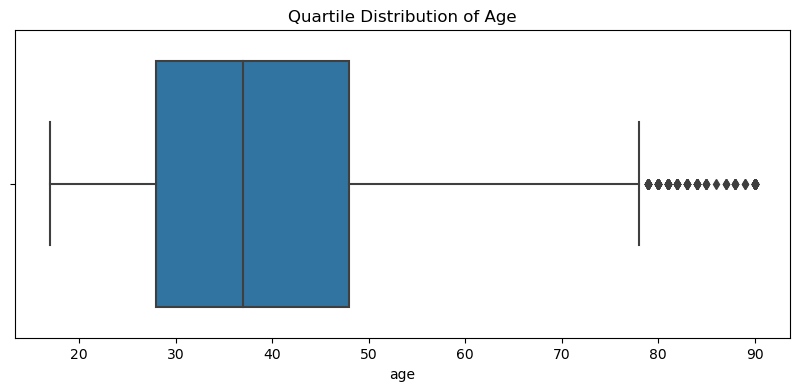

In [24]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df1['age'], data=df1)
plt.title('Quartile Distribution of Age')
plt.show()

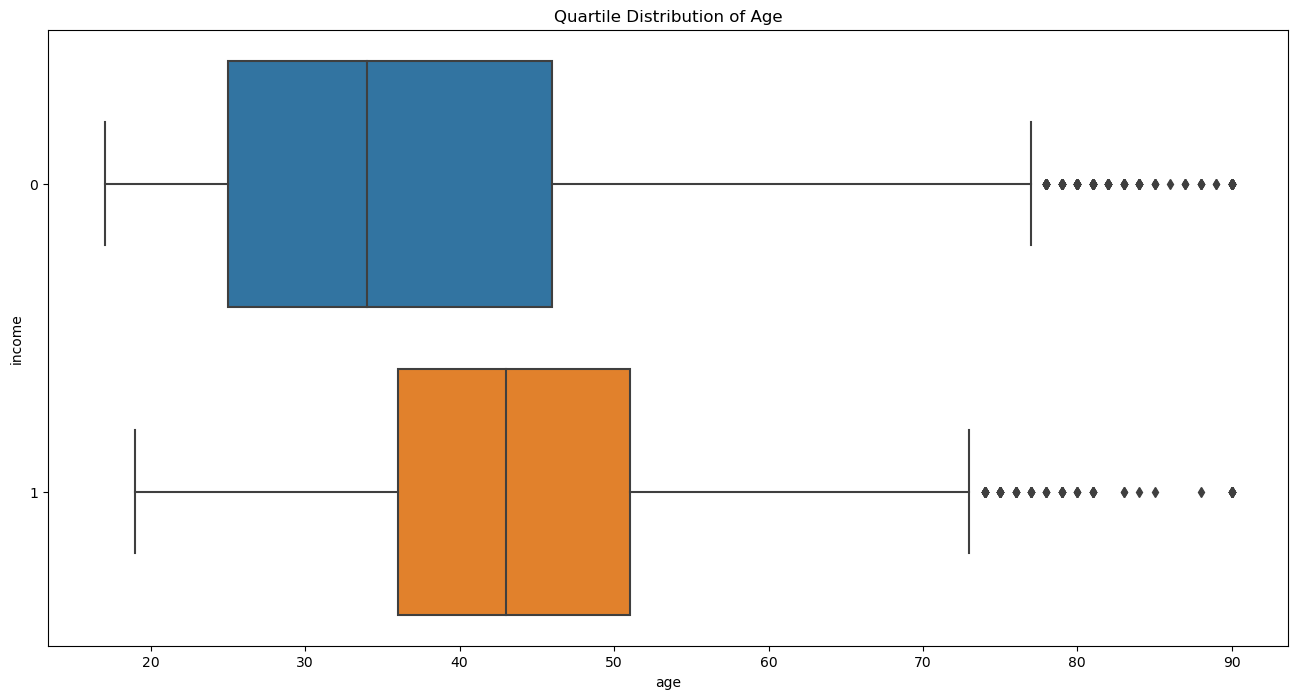

In [25]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df1['age'], y=df1['income'].astype('category'), data=df1)
plt.title('Quartile Distribution of Age')
plt.show()

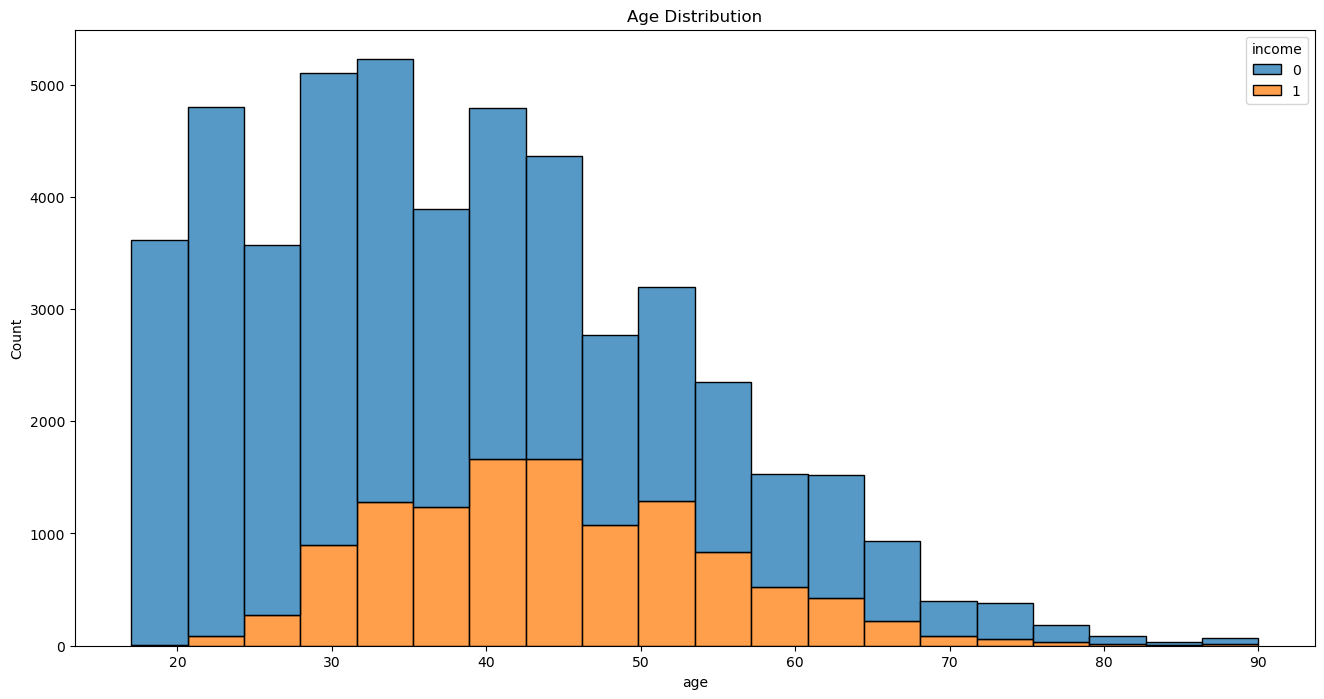

In [26]:
plt.figure(figsize=(16, 8))
sns.histplot(data=df1, x='age', hue='income', bins=20, multiple='stack')
plt.title('Age Distribution')
plt.show()

In [27]:
# Create Quartile bins to covert age to categorical data
df1['age'] = pd.qcut(df1['age'], q=[0, 0.25, 0.5, 0.75, 1.0], labels=['Q1', 'Q2', 'Q3', 'Q4'])

In [28]:
# We perform Label encoding to preserve ordinality
df1['age'] = le.fit_transform(df1['age'])
df1['age'] = df1['age'].astype(int)

In [29]:
print(df1['age'].describe())
df1.groupby('age').size()

count    48790.000000
mean         1.453167
std          1.124106
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: age, dtype: float64


age
0    13262
1    11674
2    12336
3    11518
dtype: int64

In [30]:
df1['age'].corr(df1['income'])

0.2681452112263663

### **Marital-status Attribute(Label Encoding)**

In [31]:
print(df1['marital-status'].describe())
df1.groupby('marital-status').size()

count                  48790
unique                     7
top       Married-civ-spouse
freq                   22366
Name: marital-status, dtype: object


marital-status
Divorced                  6630
Married-AF-spouse           37
Married-civ-spouse       22366
Married-spouse-absent      627
Never-married            16082
Separated                 1530
Widowed                   1518
dtype: int64

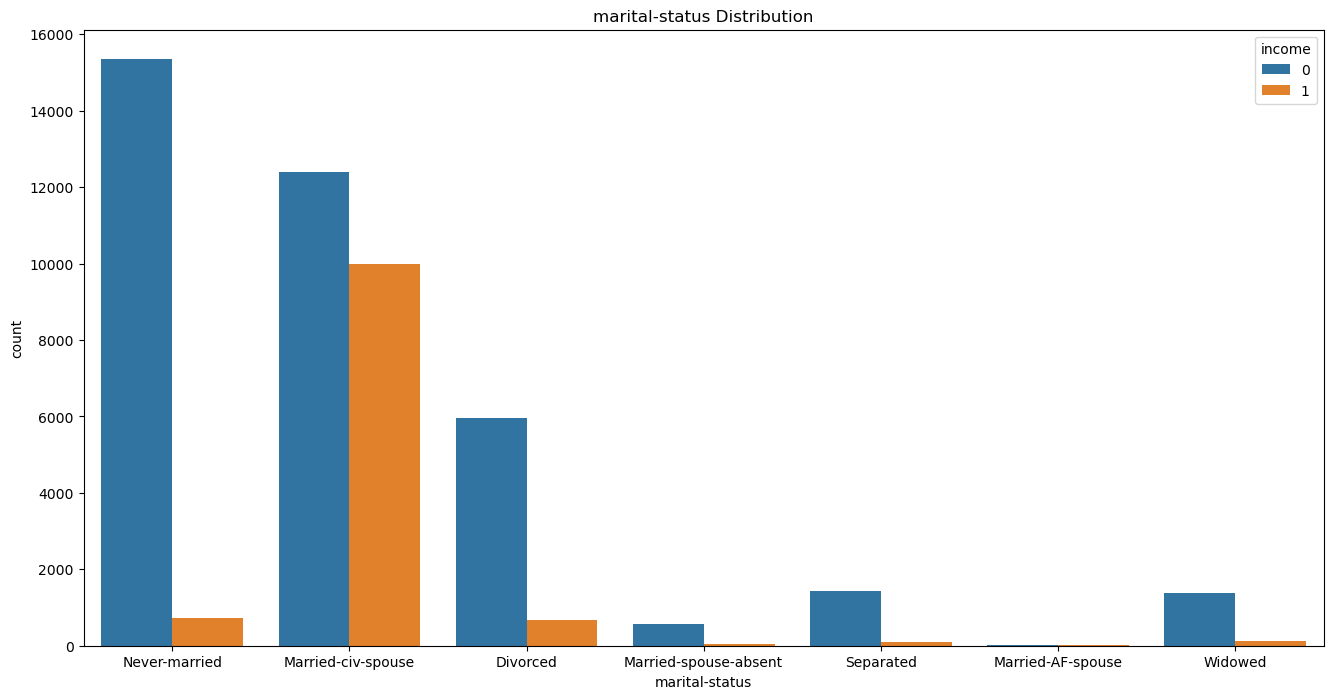

In [32]:
plt.figure(figsize=(16, 8))
sns.countplot(data=df1, x='marital-status',hue='income')
plt.title('marital-status Distribution')
plt.show()

In [33]:
# We perform Label encoding to preserve relatioship
df1['marital-status'] = le.fit_transform(df1['marital-status'])
df1['marital-status'] = df1['marital-status'].astype(int)
df1.groupby('marital-status').size()

marital-status
0     6630
1       37
2    22366
3      627
4    16082
5     1530
6     1518
dtype: int64

In [34]:
df1['marital-status'].corr(df1['income'])

-0.19885460541939087

### **Relationship Attribute(Label Encoding)**

In [35]:
print(df1['relationship'].describe())
df1.groupby('relationship').size()

count       48790
unique          6
top       Husband
freq        19703
Name: relationship, dtype: object


relationship
Husband           19703
Not-in-family     12557
Other-relative     1506
Own-child          7569
Unmarried          5124
Wife               2331
dtype: int64

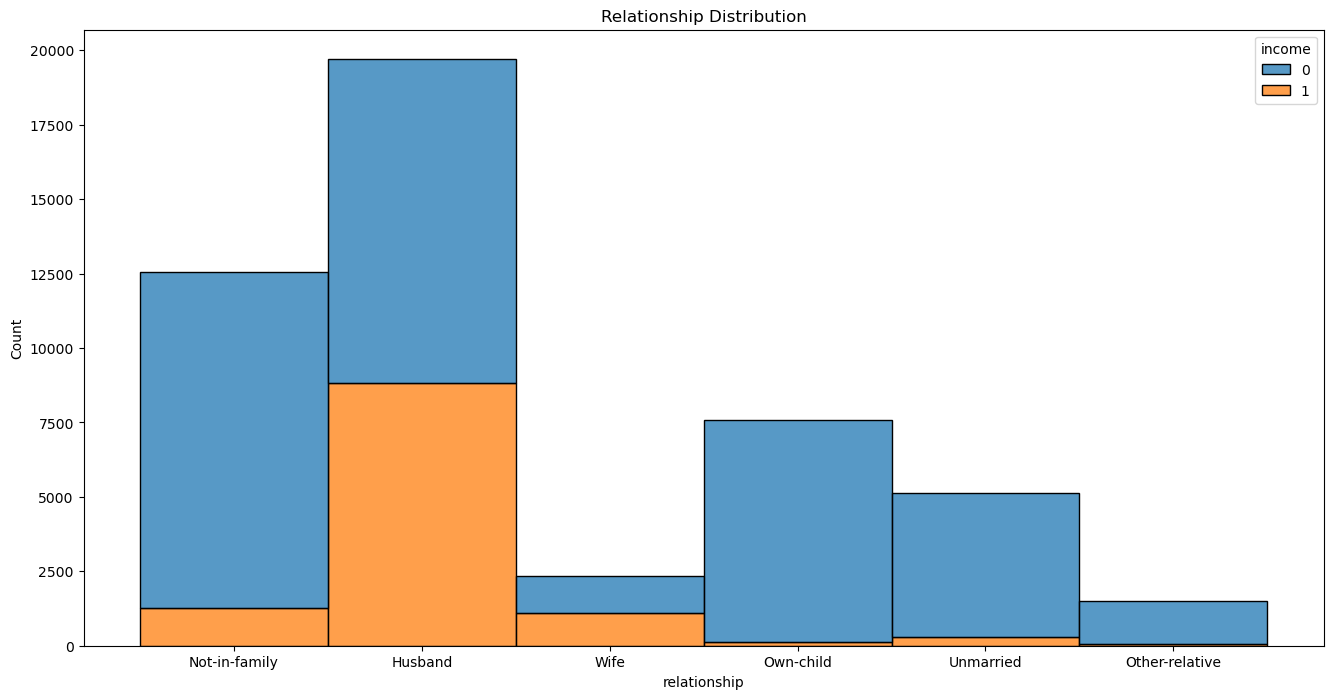

In [36]:
plt.figure(figsize=(16, 8))
sns.histplot(data=df1, x='relationship', hue='income', multiple='stack')
plt.title('Relationship Distribution')
plt.show()

In [37]:
# We perform Label encoding to preserve ordinality
df1['relationship'] = le.fit_transform(df1['relationship'])
df1['relationship'] = df1['relationship'].astype(int)
df1.groupby('relationship').size()

relationship
0    19703
1    12557
2     1506
3     7569
4     5124
5     2331
dtype: int64

In [38]:
df1['relationship'].corr(df1['income'])

-0.2531745679760194

### **Sex Attribute(Label Encoding)**

In [39]:
print(df1['sex'].describe())
df1.groupby('sex').size()

count     48790
unique        2
top        Male
freq      32614
Name: sex, dtype: object


sex
Female    16176
Male      32614
dtype: int64

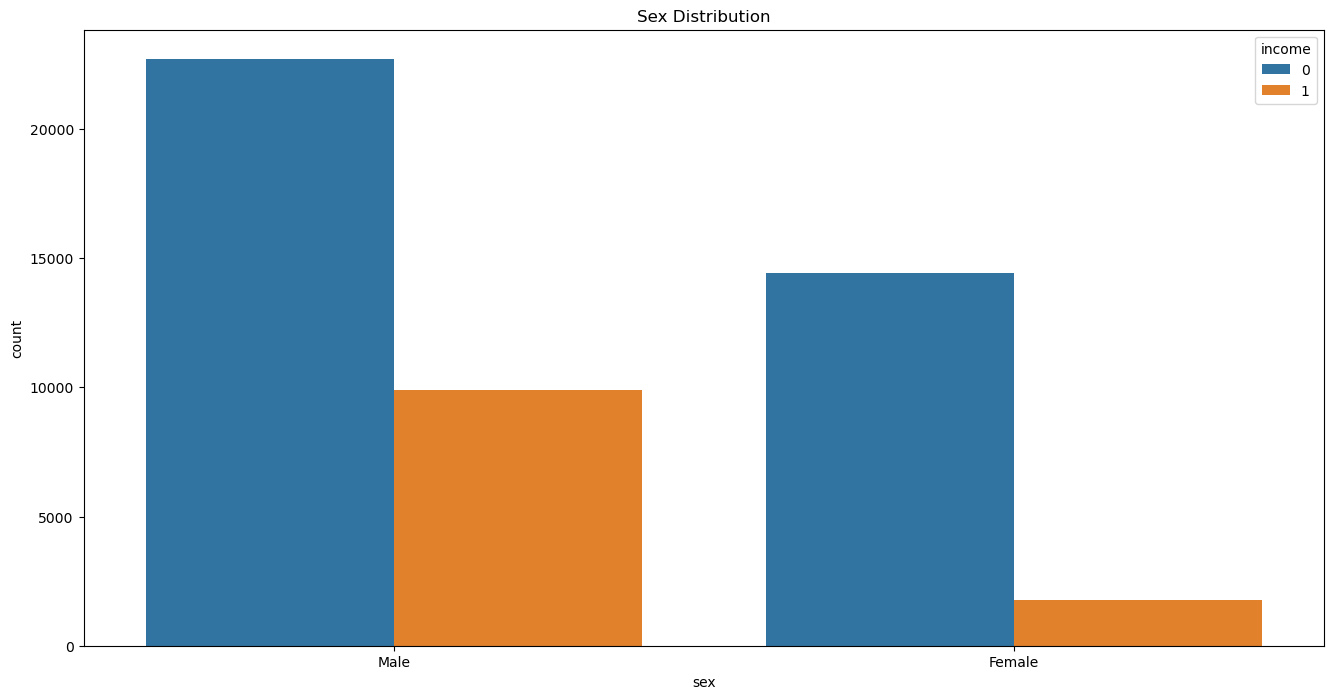

In [40]:
plt.figure(figsize=(16, 8))
sns.countplot(data=df1, x='sex', hue='income')
plt.title('Sex Distribution')
plt.show()

In [41]:
# We perform Label encoding to preserve ordinality
df1['sex'] = le.fit_transform(df1['sex'])
df1['sex'] = df1['sex'].astype(int)
df1.groupby('sex').size()

sex
0    16176
1    32614
dtype: int64

In [42]:
df1['sex'].corr(df1['income'])

0.2146393426347253

In [43]:
df1['education-num'].corr(df1['income'])

0.33280186784084426

## **Frequency Encoding**

### **Workclass Attribute(Frequency Encoding)**

In [44]:
print(df1['workclass'].describe())
df1.groupby('workclass').size()

count       48790
unique          8
top       Private
freq        36655
Name: workclass, dtype: object


workclass
Federal-gov          1432
Local-gov            3136
Never-worked           10
Private             36655
Self-emp-inc         1694
Self-emp-not-inc     3861
State-gov            1981
Without-pay            21
dtype: int64

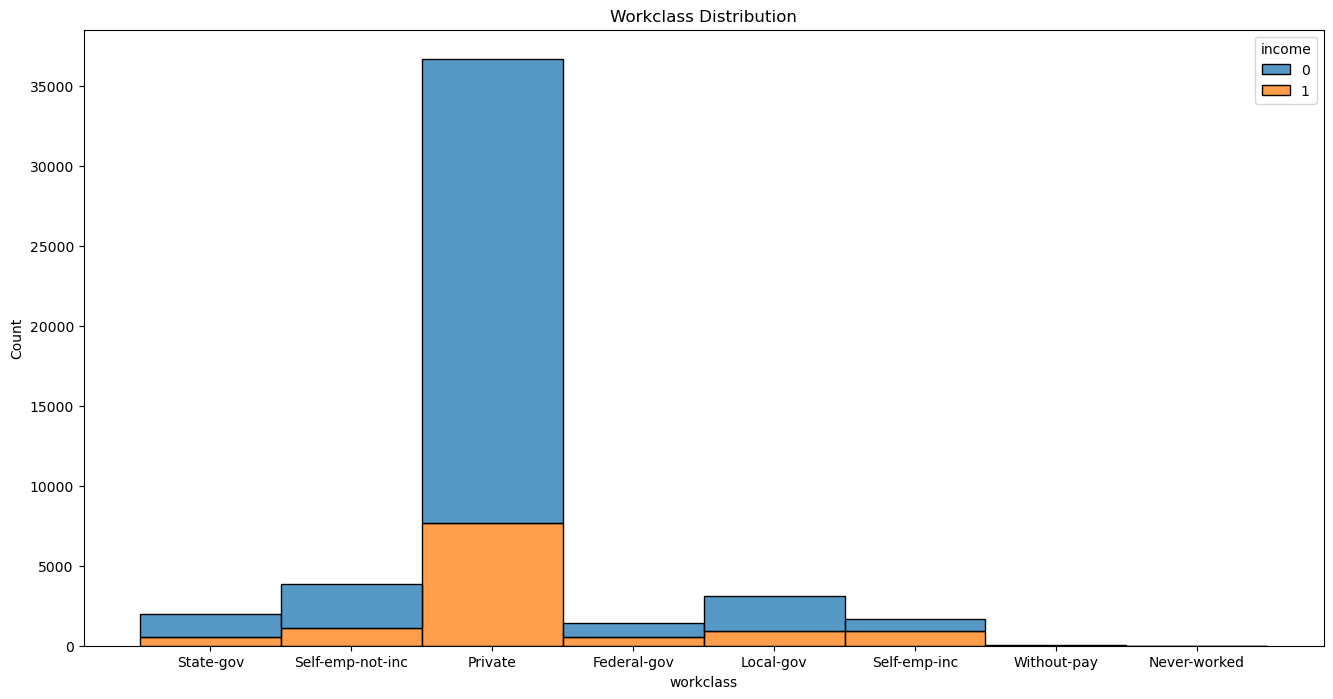

In [45]:
plt.figure(figsize=(16, 8))
sns.histplot(data=df1, x='workclass', hue='income', bins=20, multiple='stack')
plt.title('Workclass Distribution')
plt.show()

In [46]:
# We perform frequency encoding on this as label encoding might introduce ordinality.


In [47]:
#  Frequency Encoding for 'workclass':

workclass_frequency = df1['workclass'].value_counts(normalize=True).to_dict()

# Map the frequency encoding to the 'workclass' column
df1['workclass'] = df1['workclass'].map(workclass_frequency).astype(float)
print(df1['workclass'].describe())
df1.groupby('workclass').size()

count    48790.000000
mean         0.578533
std          0.300396
min          0.000205
25%          0.751281
50%          0.751281
75%          0.751281
max          0.751281
Name: workclass, dtype: float64


workclass
0.000205       10
0.000430       21
0.029350     1432
0.034720     1694
0.040603     1981
0.064275     3136
0.079135     3861
0.751281    36655
dtype: int64

In [48]:
df1['workclass'].corr(df1['income']) #Fix this error

-0.1276238177355482

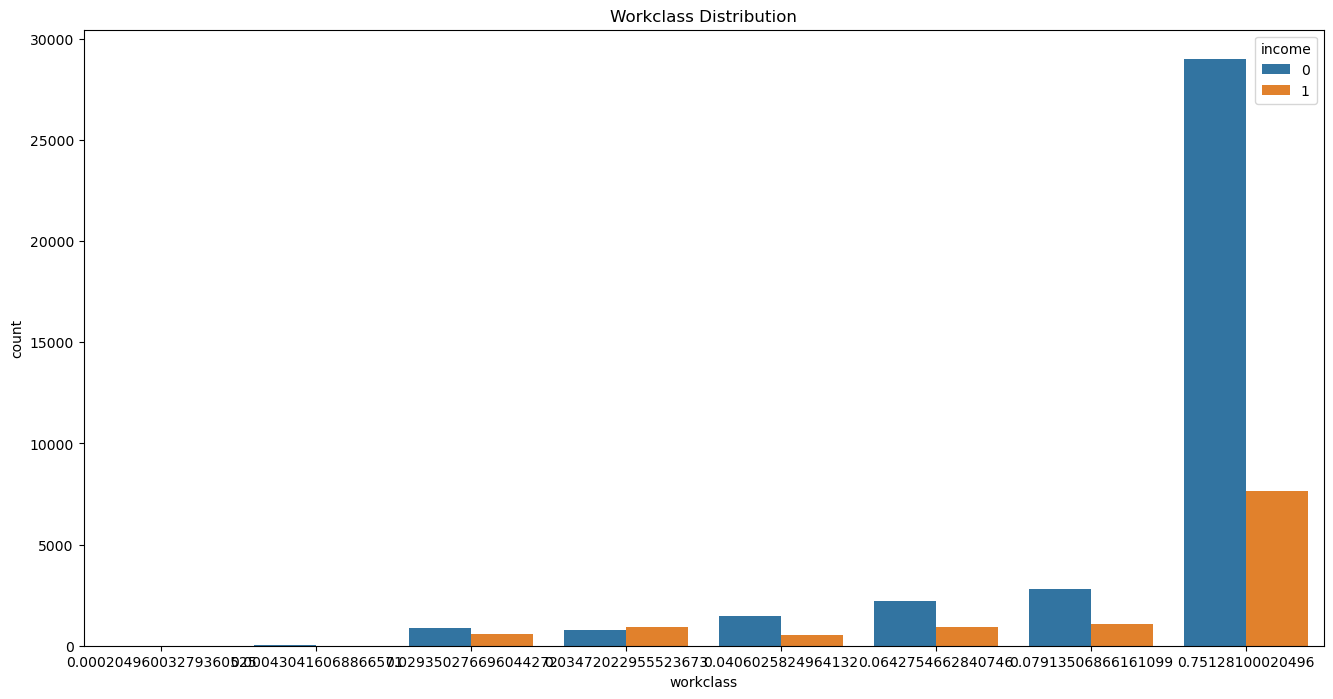

In [49]:
plt.figure(figsize=(16, 8))
sns.countplot(data=df1, x='workclass', hue='income')
plt.title('Workclass Distribution')
plt.show()

### **Occupation Attribute(Frequency Encoding)**

In [50]:
print(df1['occupation'].describe())
df.groupby('occupation').size()

count              48790
unique                15
top       Prof-specialty
freq                6165
Name: occupation, dtype: object


occupation
Adm-clerical         5606
Armed-Forces           15
Craft-repair         6102
Exec-managerial      6082
Farming-fishing      1485
Handlers-cleaners    2071
Machine-op-inspct    3017
Other                2805
Other-service        4919
Priv-house-serv       240
Prof-specialty       6165
Protective-serv       982
Sales                5501
Tech-support         1445
Transport-moving     2355
dtype: int64

Text(0.5, 1.0, 'Occupation Distribution')

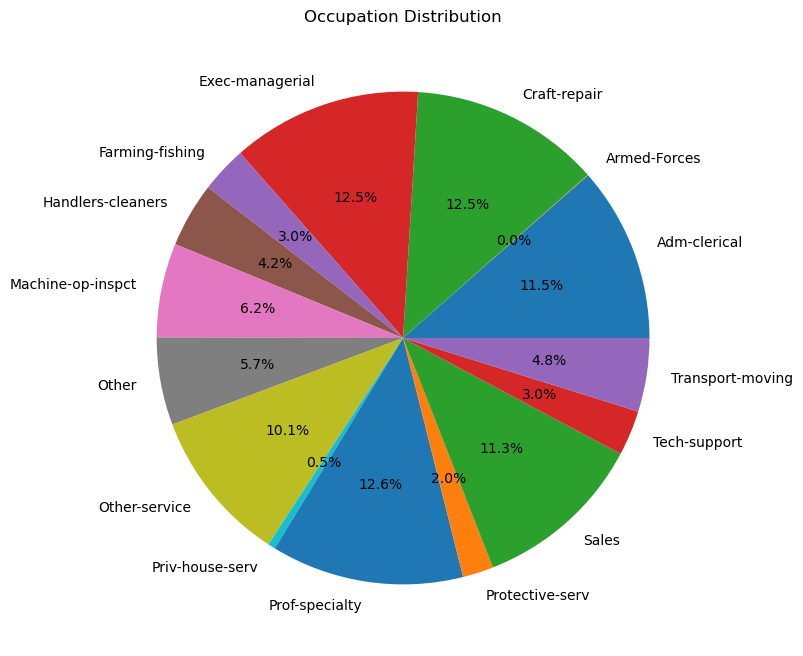

In [51]:
plt.figure(figsize=(16, 8))
plt.pie(df1.groupby('occupation').size(), labels=df1.groupby('occupation').size().index, autopct='%1.1f%%')
plt.title('Occupation Distribution')

Text(0.5, 1.0, 'Occupation Distribution')

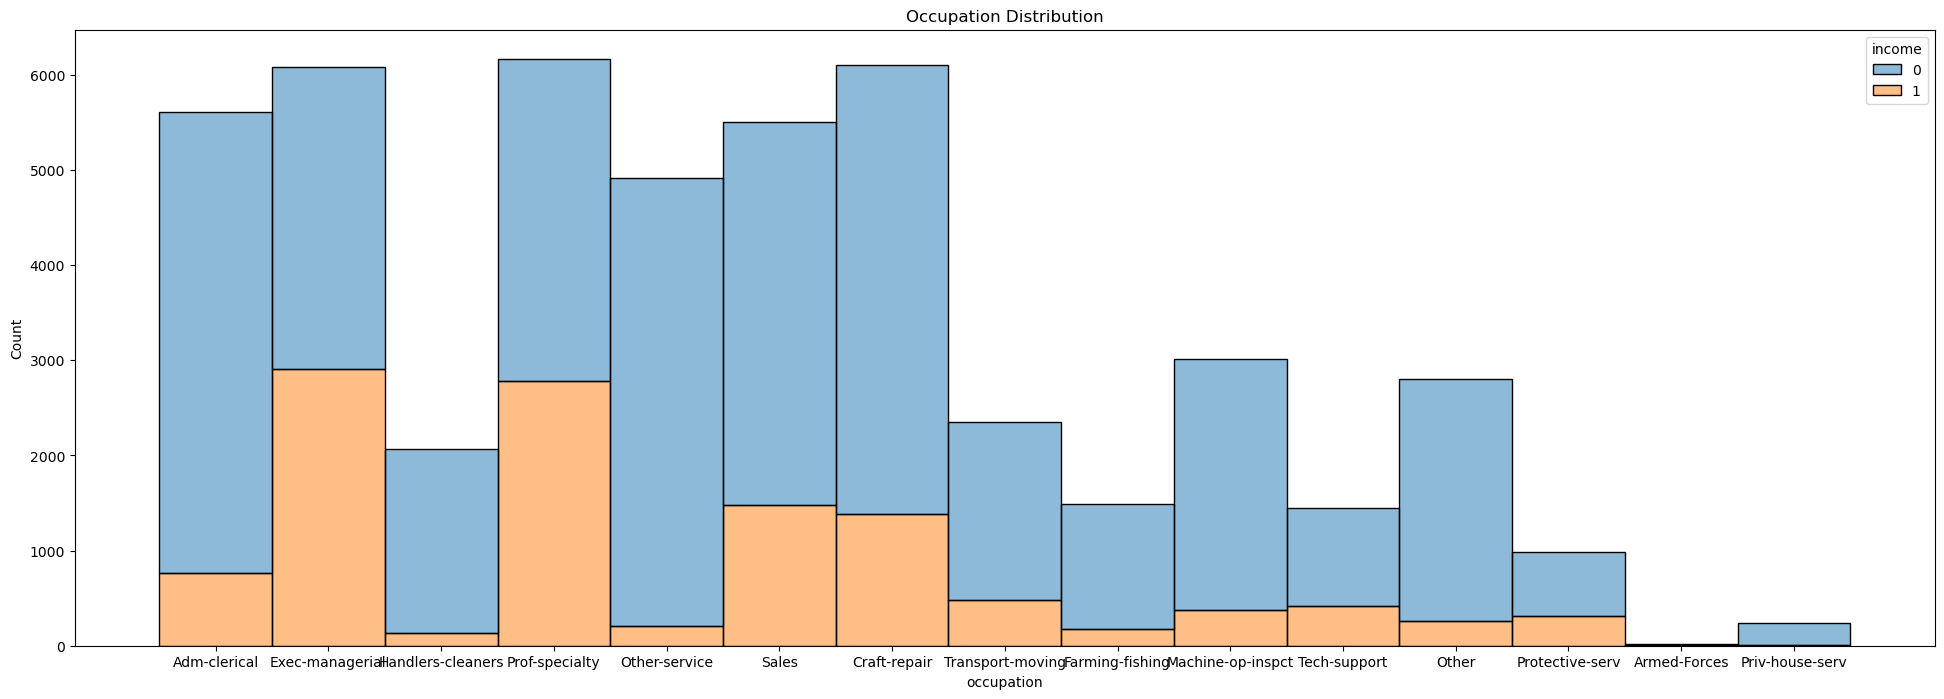

In [52]:
plt.figure(figsize=(24, 8))
sns.histplot(data=df1, x='occupation', hue='income', multiple='stack', alpha=0.5)
plt.title('Occupation Distribution')

In [53]:
#  Frequency Encoding for 'occupation':

occupation_frequency = df1['occupation'].value_counts(normalize=True).to_dict()

# Map the frequency encoding to the 'occupation' column
df1['occupation'] = df1['occupation'].map(occupation_frequency).astype(float)
print(df1['occupation'].describe())
df1.groupby('occupation').size()

count    48790.000000
mean         0.096720
std          0.034770
min          0.000307
25%          0.061836
50%          0.112749
75%          0.125067
max          0.126358
Name: occupation, dtype: float64


occupation
0.000307      15
0.004919     240
0.020127     982
0.029617    1445
0.030437    1485
0.042447    2071
0.048268    2355
0.057491    2805
0.061836    3017
0.100820    4919
0.112749    5501
0.114901    5606
0.124657    6082
0.125067    6102
0.126358    6165
dtype: int64

In [54]:
df1['occupation'].corr(df1['income'])

0.17008293499649746

### **Race Attribute(Frequency Encoding)**

In [55]:
print(df1['race'].describe())
df1.groupby('race').size()

count     48790
unique        5
top       White
freq      41714
Name: race, dtype: object


race
Amer-Indian-Eskimo      470
Asian-Pac-Islander     1517
Black                  4683
Other                   406
White                 41714
dtype: int64

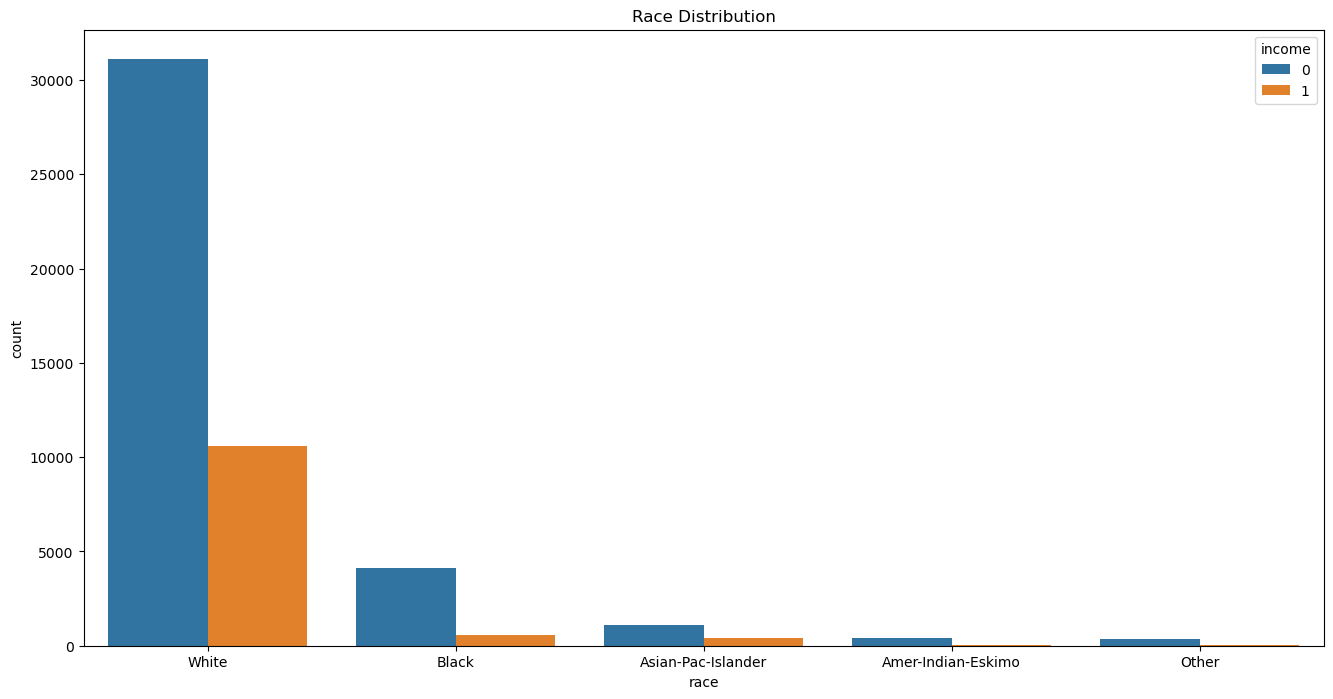

In [56]:
plt.figure(figsize=(16, 8))
sns.countplot(data=df1, x='race', hue='income')
plt.title('Race Distribution')
plt.show()

In [57]:
# We do frequency encoding cos there is no ordinality in races and we don't want to introduce any.
#  Frequency Encoding for 'race':

race_frequency = df1['race'].value_counts(normalize=True).to_dict()

# Map the frequency encoding to the 'race' column
df1['race'] = df1['race'].map(race_frequency).astype(float)
print(df1['race'].describe())
df1.groupby('race').size()

count    48790.000000
mean         0.741316
std          0.276278
min          0.008321
25%          0.854970
50%          0.854970
75%          0.854970
max          0.854970
Name: race, dtype: float64


race
0.008321      406
0.009633      470
0.031092     1517
0.095983     4683
0.854970    41714
dtype: int64

In [58]:
df1['race'].corr(df1['income'])

0.08209622758729976

### **Native-Country Attribute(Frequency Encoding)**

In [59]:
print(df1['native-country'].describe())
df1.groupby('native-country').size()

count             48790
unique               41
top       United-States
freq              44648
Name: native-country, dtype: object


native-country
Cambodia                         28
Canada                          182
China                           122
Columbia                         85
Cuba                            138
Dominican-Republic              103
Ecuador                          45
El-Salvador                     155
England                         127
France                           38
Germany                         206
Greece                           49
Guatemala                        86
Haiti                            75
Holand-Netherlands                1
Honduras                         20
Hong                             30
Hungary                          19
India                           151
Iran                             59
Ireland                          37
Italy                           105
Jamaica                         106
Japan                            92
Laos                             23
Mexico                          943
Nicaragua                        49
Outlying-US(G

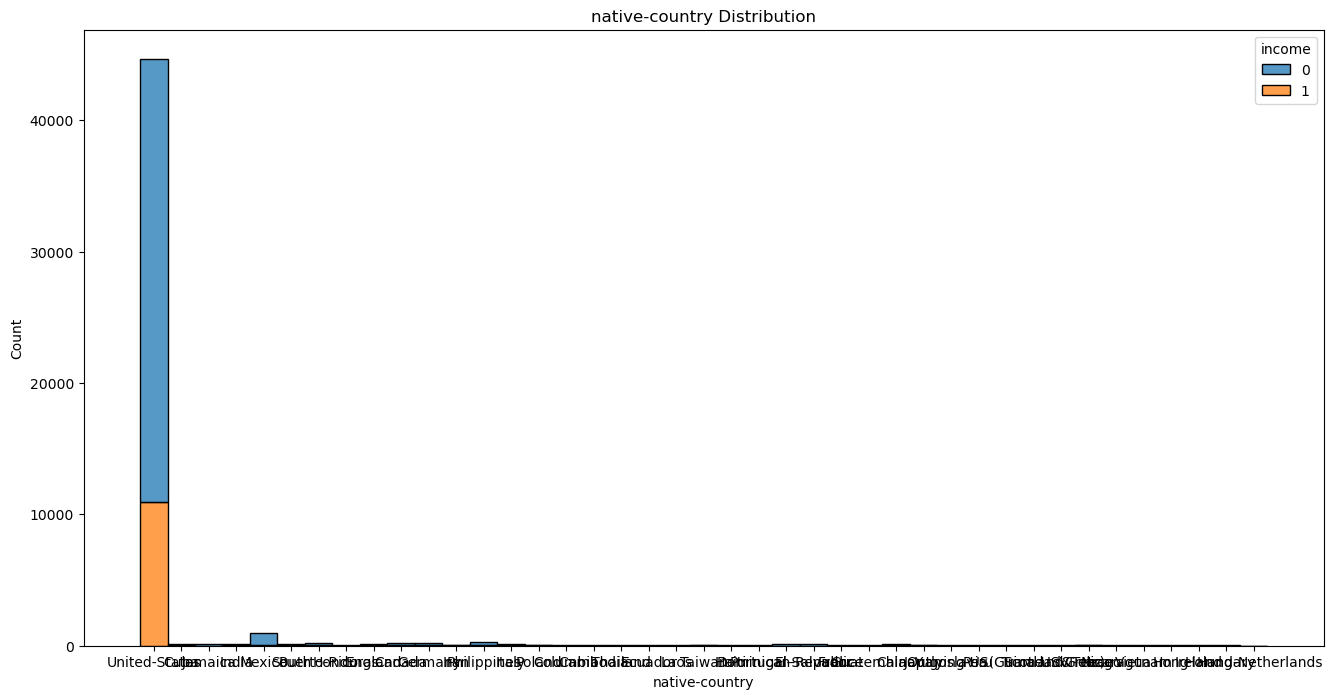

In [60]:
plt.figure(figsize=(16, 8))
sns.histplot(data=df1, x='native-country', hue='income', multiple='stack')
plt.title('native-country Distribution')
plt.show()

In [61]:
#  Frequency Encoding for 'race':

country_frequency = df1['native-country'].value_counts(normalize=True).to_dict()

# Map the frequency encoding to the 'native-country' column
df1['native-country'] = df1['native-country'].map(country_frequency).astype(float)
print(df1['native-country'].describe())
df1.groupby('native-country').size()

count    48790.000000
mean         0.837965
std          0.253278
min          0.000020
25%          0.915106
50%          0.915106
75%          0.915106
max          0.915106
Name: native-country, dtype: float64


native-country
0.000020        1
0.000389       19
0.000410       20
0.000430       21
0.000471       69
0.000553       27
0.000574       28
0.000615       60
0.000758       37
0.000779       38
0.000922       45
0.000943       46
0.001004       98
0.001209       59
0.001332       65
0.001373       67
0.001537       75
0.001742       85
0.001763      172
0.001783       87
0.001886       92
0.002111      103
0.002152      105
0.002173      106
0.002357      115
0.002501      122
0.002603      127
0.002828      138
0.003095      151
0.003177      155
0.003730      182
0.003771      184
0.004222      206
0.006026      294
0.019328      943
0.915106    44648
dtype: int64

In [62]:
# Binary encoding gives correlation of 0.0323
df1['native-country'].corr(df1['income'])

0.03729405741221734

In [63]:
df1.dtypes

age                 int64
workclass         float64
fnlwgt              int64
education          object
education-num       int64
marital-status      int64
occupation        float64
relationship        int64
race              float64
sex                 int64
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country    float64
income              int64
dtype: object

## **MinMax Scaler**

### **fnlwgt Attribute(MinMax Scaler)**

In [64]:
print(df1['fnlwgt'].describe())
df1.groupby('fnlwgt').size()

count    4.879000e+04
mean     1.896690e+05
std      1.056172e+05
min      1.228500e+04
25%      1.175550e+05
50%      1.781385e+05
75%      2.376062e+05
max      1.490400e+06
Name: fnlwgt, dtype: float64


fnlwgt
12285      1
13492      1
13769      3
13862      1
14878      1
          ..
1268339    1
1366120    1
1455435    1
1484705    1
1490400    1
Length: 28523, dtype: int64

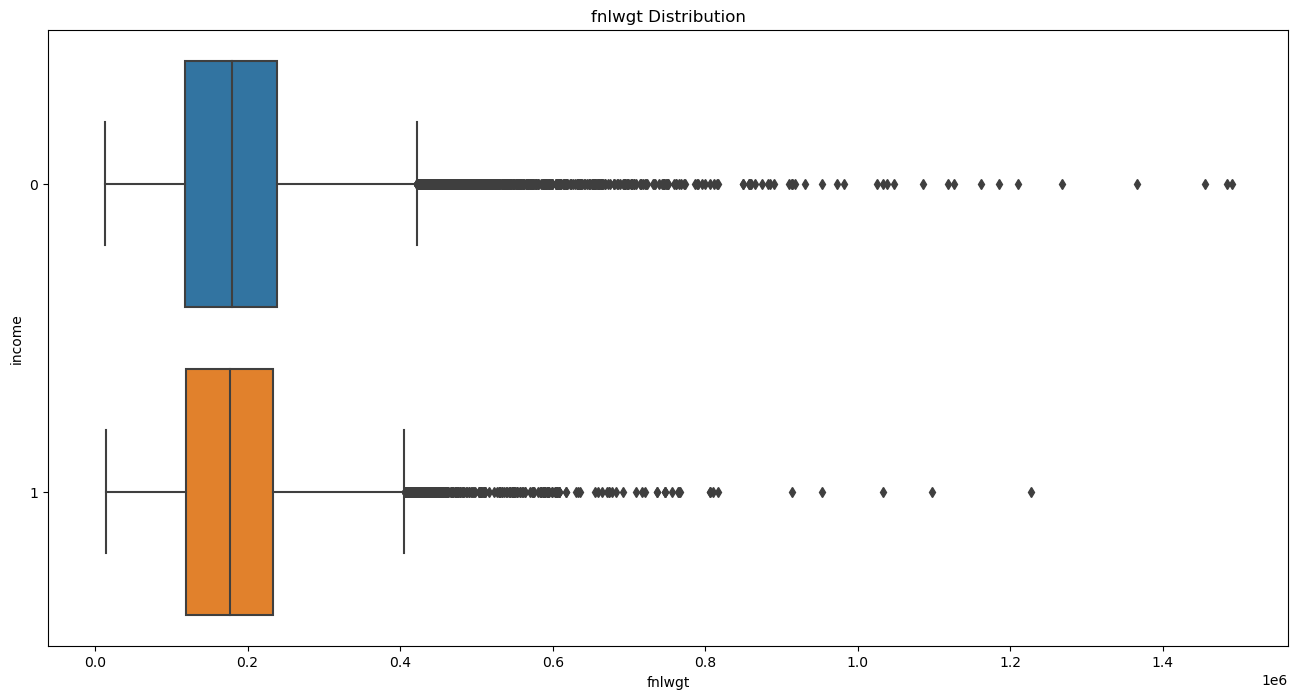

In [65]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df1, x='fnlwgt', y=df1['income'].astype('category'))
plt.title('fnlwgt Distribution')
plt.show()

In [66]:
df1['fnlwgt'].corr(df1['income'])

-0.006308960973416992

In [67]:
df1['fnlwgt'] = mms.fit_transform(df[['fnlwgt']])
print(df1['fnlwgt'].describe())
df1.groupby('fnlwgt').size()

count    48790.000000
mean         0.120007
std          0.071454
min          0.000000
25%          0.071219
50%          0.112206
75%          0.152438
max          1.000000
Name: fnlwgt, dtype: float64


fnlwgt
0.000000    1
0.000817    1
0.001004    3
0.001067    1
0.001754    1
           ..
0.849767    1
0.915920    1
0.976345    1
0.996147    1
1.000000    1
Length: 28523, dtype: int64

## **Standard Scaler**

### **Capital-Gain Attribute**

In [68]:
print(df1['capital-gain'].describe())
df1.groupby('capital-gain').size()

count    48790.000000
mean      1080.217688
std       7455.905921
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64


capital-gain
0        44755
114          8
401          5
594         52
914         10
         ...  
25236       14
27828       58
34095        6
41310        3
99999      244
Length: 123, dtype: int64

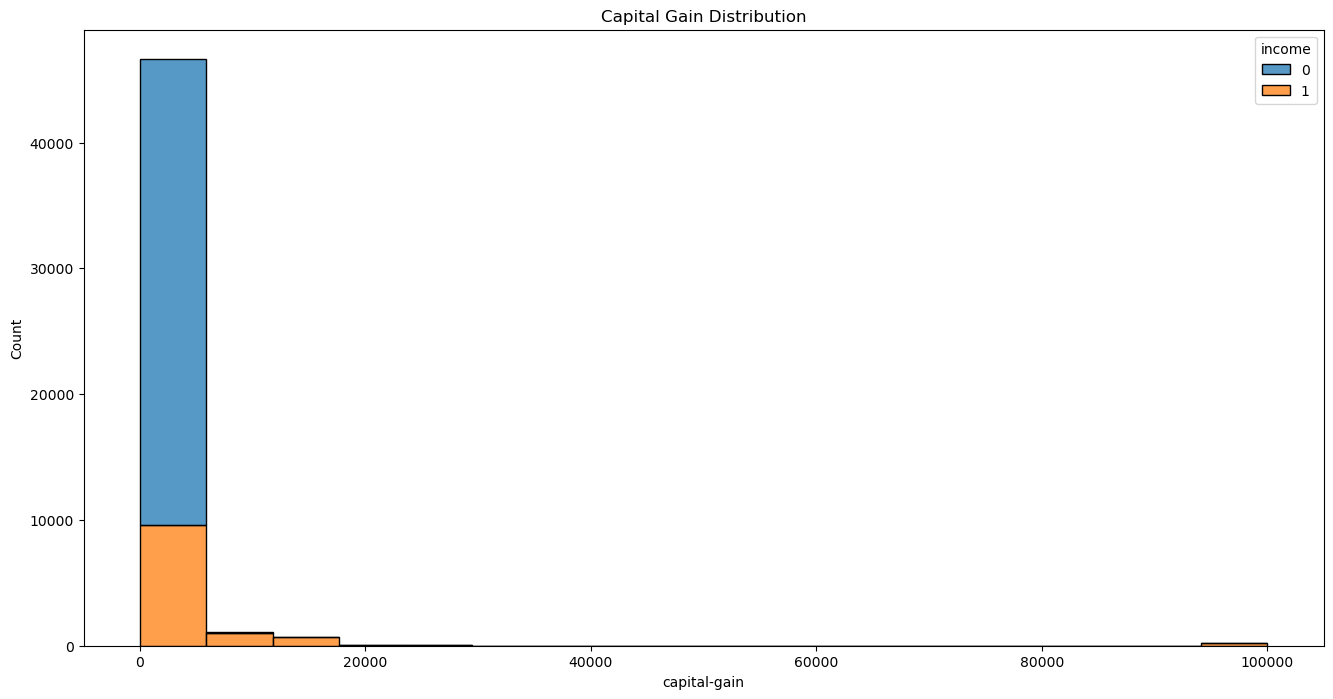

In [69]:
plt.figure(figsize=(16, 8))
sns.histplot(data=df1, x='capital-gain', hue='income', multiple='stack')
plt.title('Capital Gain Distribution')
plt.show()

In [70]:
# Standard Scaler Transform
df1['capital-gain'] = std.fit_transform(df[['capital-gain']])

In [71]:
df1['capital-gain'].corr(df1['income'])

0.22304731213351325

### **Capital-Loss Attribute**

In [72]:
print(df1['capital-loss'].describe())
df1.groupby('capital-loss').size()

count    48790.000000
mean        87.595573
std        403.209129
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital-loss, dtype: float64


capital-loss
0       46508
155         1
213         5
323         5
419         3
        ...  
3175        2
3683        2
3770        4
3900        2
4356        3
Length: 99, dtype: int64

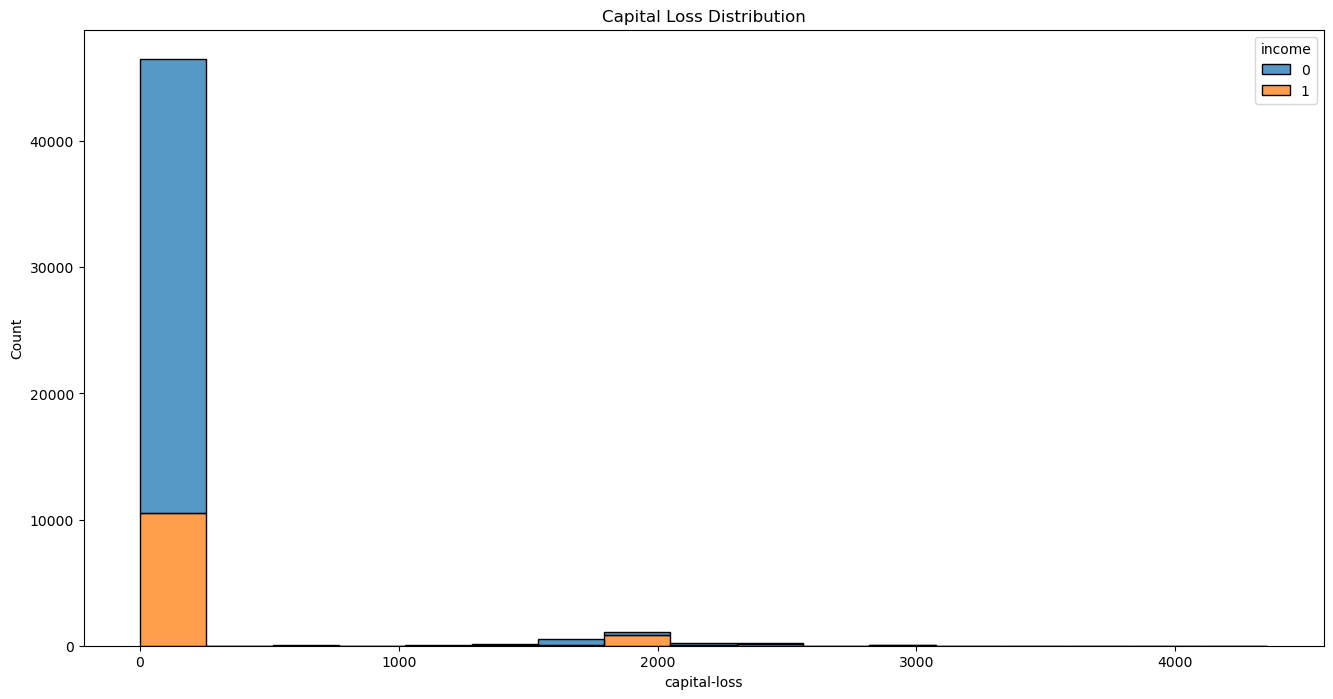

In [73]:
plt.figure(figsize=(16, 8))
sns.histplot(data=df1, x='capital-loss', hue='income', multiple='stack')
plt.title('Capital Loss Distribution')
plt.show()

In [74]:
# Standard Scaler Transform
df1['capital-loss'] = std.fit_transform(df[['capital-loss']])

In [75]:
df1['capital-loss'].corr(df1['income'])

0.1475416726716553

### **Hours-Per-Week Attribute**

In [76]:
print(df1['hours-per-week'].describe())
df1.groupby('hours-per-week').size()

count    48790.000000
mean        40.425886
std         12.392729
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours-per-week, dtype: float64


hours-per-week
1      27
2      53
3      59
4      84
5      95
     ... 
95      2
96      9
97      2
98     14
99    137
Length: 96, dtype: int64

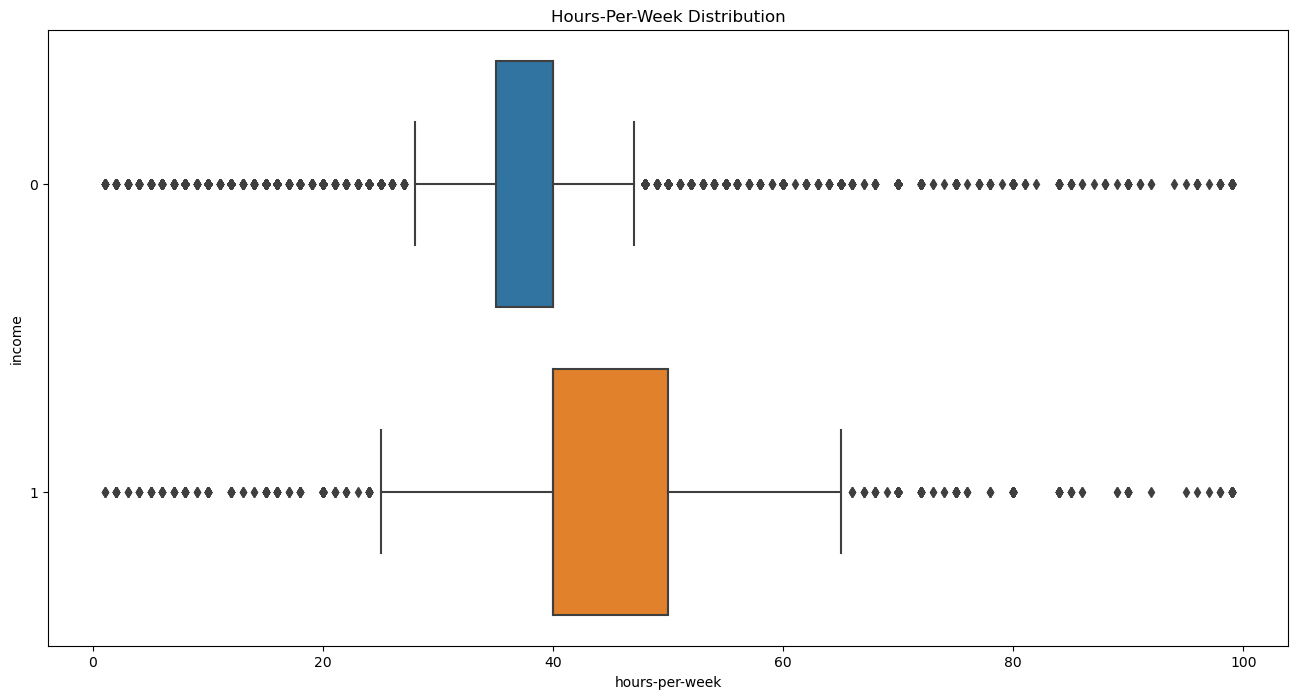

In [77]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df1, x='hours-per-week', y=df1['income'].astype('category'))
plt.title('Hours-Per-Week Distribution')
plt.show()

In [78]:
# Standard Scaler Transform
df1['hours-per-week'] = std.fit_transform(df[['hours-per-week']])

In [79]:
df1['hours-per-week'].corr(df1['income'])

0.22766351292595563

In [80]:
# For capital-gain, capital-loss, hours-per-week if we do bins for categories we get a significantly lower correlation. So i feel standard scaler is much better.

### **Education and Education-num Attribute**

In [81]:
# We drop Education as decided
df1 = df1.drop('education', axis=1)
df1.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,2,0.040603,0.044131,13,4,0.114901,1,0.854970,1,0.146702,-0.217248,-0.034366,0.915106,0
1,3,0.079135,0.048052,13,2,0.124657,0,0.854970,1,-0.144882,-0.217248,-2.213085,0.915106,0
2,2,0.751281,0.137581,9,0,0.042447,1,0.854970,1,-0.144882,-0.217248,-0.034366,0.915106,0
3,3,0.751281,0.150486,7,2,0.042447,0,0.095983,1,-0.144882,-0.217248,-0.034366,0.915106,0
4,0,0.751281,0.220635,13,2,0.126358,5,0.095983,0,-0.144882,-0.217248,-0.034366,0.002828,0


In [82]:
print(df1['education-num'].describe())
df1.groupby('education-num').size()

count    48790.000000
mean        10.078807
std          2.570046
min          1.000000
25%          9.000000
50%         10.000000
75%         12.000000
max         16.000000
Name: education-num, dtype: float64


education-num
1        81
2       245
3       507
4       954
5       756
6      1389
7      1812
8       655
9     15770
10    10863
11     2060
12     1601
13     8013
14     2656
15      834
16      594
dtype: int64

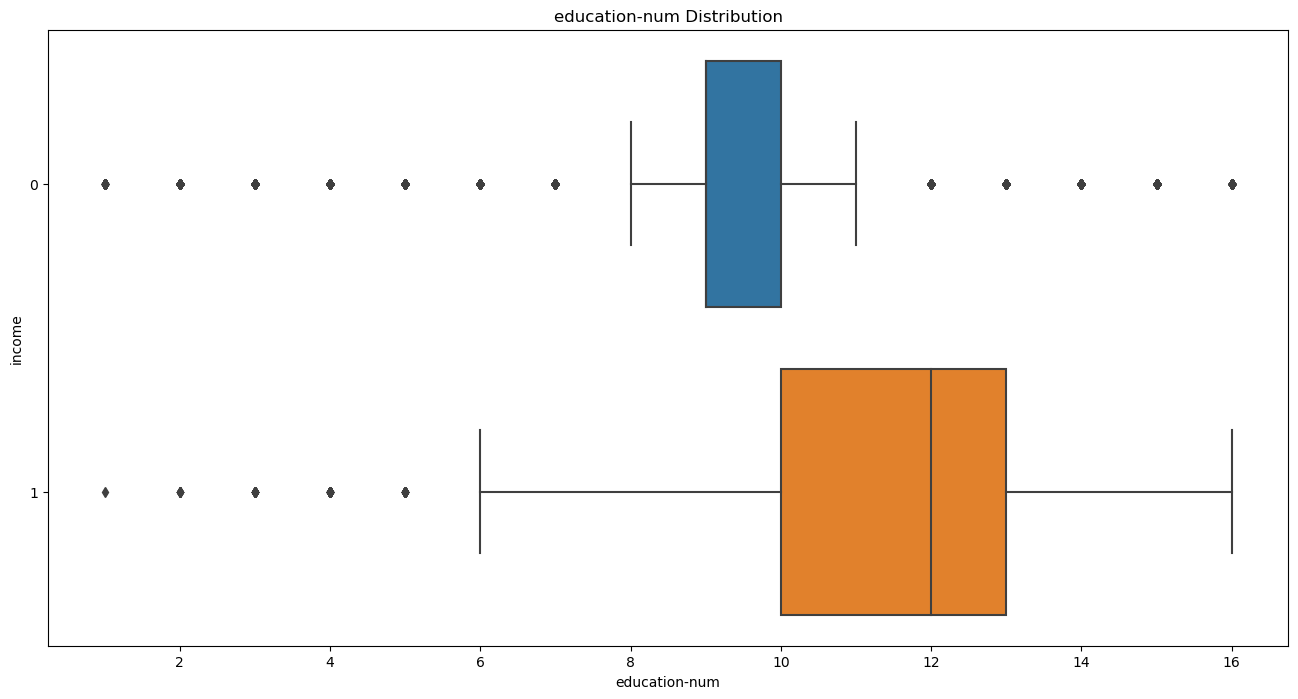

In [83]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df1, x='education-num', y=df1['income'].astype('category'))
plt.title('education-num Distribution')
plt.show()

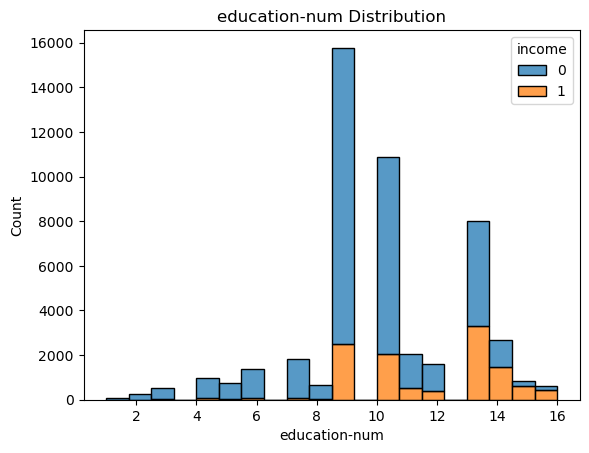

In [84]:
sns.histplot(data=df1, x='education-num', hue='income', bins=20, multiple='stack')
plt.title('education-num Distribution')
plt.show()

## **Data Splitting**

In [85]:
# DF for decision Tree
df2 = df1

In [86]:
X = df1.drop('income', axis=1).astype('float32')
y = df1['income'].astype('float32')

In [87]:
# Split the data into 70% train and 30% temporary
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Split the temporary data into 50% test and 50% validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [88]:
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, X_val: {X_val.shape}')
print(f'y_train: {y_train.shape}, y_test: {y_test.shape}, y_val: {y_val.shape}')

X_train: (34153, 13), X_test: (7318, 13), X_val: (7319, 13)
y_train: (34153,), y_test: (7318,), y_val: (7319,)


In [89]:
print(X_train.describe())
print(X_train.info())
print(X_train.shape)

                age     workclass        fnlwgt  education-num  \
count  34153.000000  34153.000000  34153.000000   34153.000000   
mean       1.450824      0.577634      0.120023      10.074722   
std        1.122773      0.300884      0.071667       2.565236   
min        0.000000      0.000205      0.000000       1.000000   
25%        0.000000      0.079135      0.071201       9.000000   
50%        1.000000      0.751281      0.112048      10.000000   
75%        2.000000      0.751281      0.152615      12.000000   
max        3.000000      0.751281      1.000000      16.000000   

       marital-status    occupation  relationship          race           sex  \
count    34153.000000  34153.000000   34153.00000  34153.000000  34153.000000   
mean         2.617398      0.096639       1.44002      0.741148      0.670746   
std          1.505669      0.034818       1.60081      0.276447      0.469919   
min          0.000000      0.000307       0.00000      0.008321      0.000000   


In [90]:
print(y_train.describe())
print(y_train.info())

count    34153.000000
mean         0.239423
std          0.426702
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: income, dtype: float64
<class 'pandas.core.series.Series'>
Index: 34153 entries, 35281 to 20259
Series name: income
Non-Null Count  Dtype  
--------------  -----  
34153 non-null  float32
dtypes: float32(1)
memory usage: 400.2 KB
None


# **Models**

## **Artificial Neural Network**

### **In-Built model**



#### **Baseline Implementation**

In [91]:
# Create a sequential model
baseline_model = tf.keras.Sequential()

# Input layer (specify the input shape based on the number of features)
baseline_model.add(tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))

# Hidden layer
baseline_model.add(tf.keras.layers.Dense(units=32, activation='relu'))

# Output layer for binary classification (sigmoid activation)
baseline_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the model
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training data
baseline_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

Epoch 1/20
1068/1068 [==============================] - 1s 793us/step - loss: 0.3718 - accuracy: 0.8285 - val_loss: 0.3863 - val_accuracy: 0.8019
Epoch 2/20
1068/1068 [==============================] - 1s 693us/step - loss: 0.3369 - accuracy: 0.8412 - val_loss: 0.3329 - val_accuracy: 0.8427
Epoch 3/20
1068/1068 [==============================] - 1s 684us/step - loss: 0.3318 - accuracy: 0.8458 - val_loss: 0.3324 - val_accuracy: 0.8429
Epoch 4/20
1068/1068 [==============================] - 1s 681us/step - loss: 0.3287 - accuracy: 0.8459 - val_loss: 0.3513 - val_accuracy: 0.8330
Epoch 5/20
1068/1068 [==============================] - 1s 690us/step - loss: 0.3269 - accuracy: 0.8456 - val_loss: 0.3281 - val_accuracy: 0.8435
Epoch 6/20
1068/1068 [==============================] - 1s 723us/step - loss: 0.3259 - accuracy: 0.8470 - val_loss: 0.3274 - val_accuracy: 0.8470
Epoch 7/20
1068/1068 [==============================] - 1s 686us/step - loss: 0.3253 - accuracy: 0.8472 - val_loss: 0.3252 -

In [92]:
y_test_pred = baseline_model.predict(X_test)
y_test_pred_binary = np.round(y_test_pred)

229/229 [==============================] - 0s 367us/step


In [93]:
precision_test = precision_score(y_test, y_test_pred_binary)
recall_test = recall_score(y_test, y_test_pred_binary)
accuracy_test = accuracy_score(y_test, y_test_pred_binary)
f1_test = f1_score(y_test, y_test_pred_binary)
roc_auc_test = roc_auc_score(y_test, y_test_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred_binary)
class_accuracy_test = conf_matrix_test.diagonal() / conf_matrix_test.sum(axis=1)

In [94]:
# Print the test set metrics
print("Test Set Metrics:")
print("Precision: {:.4f}".format(precision_test))
print("Recall: {:.4f}".format(recall_test))
print("Accuracy: {:.4f}".format(accuracy_test))
print("F1-Score: {:.4f}".format(f1_test))
print("ROC-AUC: {:.4f}".format(roc_auc_test))

Test Set Metrics:
Precision: 0.7349
Recall: 0.5885
Accuracy: 0.8506
F1-Score: 0.6536
ROC-AUC: 0.9050


#### **Build Model**

In [95]:
# Define a function to create and compile the neural network model
def create_model(hp):
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(X_train.shape[1],)),  # Input layer
  ])

  # Add hidden layers
  for i in range(hp.Int('hidden_layers', min_value=1, max_value=5)):
    model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=256, step=32), activation='relu'))

  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification

  optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [96]:
# Initialize lists to store evaluation metrics
precisions, recalls, accuracies, f1_scores, roc_aucs, class_accuracies = [], [], [], [], [], []

#### **Hyperparameter Tuning to Get Best Model**

In [97]:
# Initialize the RandomSearch tuner
tuner = RandomSearch(
    create_model,  # Model-building function
    objective='val_accuracy',  # Metric to optimize
    max_trials=10,  # Number of hyperparameter combinations to try
    directory='Ann_Tuning',  # Directory to save results
    project_name='DMT_project_ANN_Tuning'  # Name for the project
)

Reloading Tuner from Ann_Tuning/DMT_project_ANN_Tuning/tuner0.json


In [98]:
# Search for the best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

In [99]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'hidden_layers': 2, 'units_0': 224, 'learning_rate': 0.01, 'units_1': 64, 'units_2': 192, 'units_3': 32}


#### **K-Fold Cross Validation**

In [100]:
# Define K-fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for train_index, val_index in kfold.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Create and compile the model
    ann_model = tuner.hypermodel.build(best_hps)

    # Train the model
    ann_model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=20, verbose=1)

    # Make predictions on the validation set
    y_val_pred = ann_model.predict(X_val_fold)
    y_val_pred_binary = np.round(y_val_pred)

    # Calculate evaluation metrics for the fold
    precision = precision_score(y_val_fold, y_val_pred_binary)
    recall = recall_score(y_val_fold, y_val_pred_binary)
    accuracy = accuracy_score(y_val_fold, y_val_pred_binary)
    f1 = f1_score(y_val_fold, y_val_pred_binary)
    roc_auc = roc_auc_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred_binary)
    class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

    # Append metrics to lists
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)
    class_accuracies.append(class_accuracy)

Epoch 1/20
961/961 [==============================] - 1s 799us/step - loss: 0.3612 - accuracy: 0.8295 - val_loss: 0.3549 - val_accuracy: 0.8355
Epoch 2/20
961/961 [==============================] - 1s 742us/step - loss: 0.3384 - accuracy: 0.8419 - val_loss: 0.3440 - val_accuracy: 0.8407
Epoch 3/20
961/961 [==============================] - 1s 774us/step - loss: 0.3338 - accuracy: 0.8439 - val_loss: 0.3391 - val_accuracy: 0.8422
Epoch 4/20
961/961 [==============================] - 1s 708us/step - loss: 0.3312 - accuracy: 0.8463 - val_loss: 0.3632 - val_accuracy: 0.8305
Epoch 5/20
961/961 [==============================] - 1s 705us/step - loss: 0.3295 - accuracy: 0.8469 - val_loss: 0.3436 - val_accuracy: 0.8390
Epoch 6/20
961/961 [==============================] - 1s 739us/step - loss: 0.3275 - accuracy: 0.8474 - val_loss: 0.3489 - val_accuracy: 0.8431
Epoch 7/20
961/961 [==============================] - 1s 700us/step - loss: 0.3294 - accuracy: 0.8462 - val_loss: 0.3336 - val_accuracy:

Epoch 17/20
961/961 [==============================] - 1s 722us/step - loss: 0.3206 - accuracy: 0.8507 - val_loss: 0.3213 - val_accuracy: 0.8405
Epoch 18/20
961/961 [==============================] - 1s 724us/step - loss: 0.3212 - accuracy: 0.8498 - val_loss: 0.3319 - val_accuracy: 0.8358
Epoch 19/20
961/961 [==============================] - 1s 709us/step - loss: 0.3217 - accuracy: 0.8493 - val_loss: 0.3219 - val_accuracy: 0.8454
Epoch 20/20
107/107 [==============================] - 0s 423us/step
Epoch 1/20
961/961 [==============================] - 1s 842us/step - loss: 0.3629 - accuracy: 0.8298 - val_loss: 0.3312 - val_accuracy: 0.8501
Epoch 2/20
961/961 [==============================] - 1s 734us/step - loss: 0.3399 - accuracy: 0.8397 - val_loss: 0.3493 - val_accuracy: 0.8384
Epoch 3/20
961/961 [==============================] - 1s 733us/step - loss: 0.3348 - accuracy: 0.8439 - val_loss: 0.3372 - val_accuracy: 0.8348
Epoch 4/20
961/961 [==============================] - 1s 781us/s

961/961 [==============================] - 1s 732us/step - loss: 0.3241 - accuracy: 0.8481 - val_loss: 0.3227 - val_accuracy: 0.8463
Epoch 13/20
961/961 [==============================] - 1s 745us/step - loss: 0.3241 - accuracy: 0.8495 - val_loss: 0.3340 - val_accuracy: 0.8392
Epoch 14/20
961/961 [==============================] - 1s 747us/step - loss: 0.3225 - accuracy: 0.8505 - val_loss: 0.3367 - val_accuracy: 0.8463
Epoch 15/20
961/961 [==============================] - 1s 712us/step - loss: 0.3230 - accuracy: 0.8502 - val_loss: 0.3202 - val_accuracy: 0.8498
Epoch 16/20
961/961 [==============================] - 1s 705us/step - loss: 0.3222 - accuracy: 0.8507 - val_loss: 0.3164 - val_accuracy: 0.8483
Epoch 17/20
961/961 [==============================] - 1s 716us/step - loss: 0.3215 - accuracy: 0.8511 - val_loss: 0.3262 - val_accuracy: 0.8460
Epoch 18/20
961/961 [==============================] - 1s 738us/step - loss: 0.3225 - accuracy: 0.8500 - val_loss: 0.3307 - val_accuracy: 0.84

961/961 [==============================] - 1s 741us/step - loss: 0.3293 - accuracy: 0.8497 - val_loss: 0.3323 - val_accuracy: 0.8515
Epoch 8/20
961/961 [==============================] - 1s 771us/step - loss: 0.3265 - accuracy: 0.8473 - val_loss: 0.3268 - val_accuracy: 0.8477
Epoch 9/20
961/961 [==============================] - 1s 711us/step - loss: 0.3251 - accuracy: 0.8480 - val_loss: 0.3264 - val_accuracy: 0.8451
Epoch 10/20
961/961 [==============================] - 1s 713us/step - loss: 0.3261 - accuracy: 0.8483 - val_loss: 0.3226 - val_accuracy: 0.8498
Epoch 11/20
961/961 [==============================] - 1s 715us/step - loss: 0.3229 - accuracy: 0.8488 - val_loss: 0.3405 - val_accuracy: 0.8492
Epoch 12/20
961/961 [==============================] - 1s 758us/step - loss: 0.3239 - accuracy: 0.8488 - val_loss: 0.3299 - val_accuracy: 0.8518
Epoch 13/20
961/961 [==============================] - 1s 729us/step - loss: 0.3226 - accuracy: 0.8493 - val_loss: 0.3214 - val_accuracy: 0.8489

In [101]:
# Print the mean metrics from cross-validation
print("Cross-Validation Metrics:")
print("Precision: {:.4f}".format(np.mean(precisions)))
print("Recall: {:.4f}".format(np.mean(recalls)))
print("Accuracy: {:.4f}".format(np.mean(accuracies)))
print("F1-Score: {:.4f}".format(np.mean(f1_scores)))
print("ROC-AUC: {:.4f}".format(np.mean(roc_aucs)))

Cross-Validation Metrics:
Precision: 0.7327
Recall: 0.5939
Accuracy: 0.8496
F1-Score: 0.6529
ROC-AUC: 0.9029


#### **Train Final Model**

In [102]:
# Train a final model on the entire training set and evaluate it on the test set
final_ann_model = tuner.hypermodel.build(best_hps)
final_ann_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 224)               3136      
                                                                 
 dense_34 (Dense)            (None, 64)                14400     
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17601 (68.75 KB)
Trainable params: 17601 (68.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [103]:
history = final_ann_model.fit(X_train, y_train, epochs=1000, verbose=1, validation_data=(X_val, y_val))

Epoch 1/1000
1068/1068 [==============================] - 2s 1ms/step - loss: 0.3583 - accuracy: 0.8324 - val_loss: 0.3559 - val_accuracy: 0.8318
Epoch 2/1000
1068/1068 [==============================] - 1s 754us/step - loss: 0.3410 - accuracy: 0.8410 - val_loss: 0.3303 - val_accuracy: 0.8485
Epoch 3/1000
1068/1068 [==============================] - 1s 792us/step - loss: 0.3317 - accuracy: 0.8449 - val_loss: 0.3313 - val_accuracy: 0.8474
Epoch 4/1000
1068/1068 [==============================] - 1s 799us/step - loss: 0.3292 - accuracy: 0.8459 - val_loss: 0.3198 - val_accuracy: 0.8456
Epoch 5/1000
1068/1068 [==============================] - 1s 816us/step - loss: 0.3269 - accuracy: 0.8477 - val_loss: 0.3209 - val_accuracy: 0.8490
Epoch 6/1000
1068/1068 [==============================] - 1s 766us/step - loss: 0.3267 - accuracy: 0.8475 - val_loss: 0.3257 - val_accuracy: 0.8474
Epoch 7/1000
1068/1068 [==============================] - 1s 745us/step - loss: 0.3242 - accuracy: 0.8482 - val_lo

1068/1068 [==============================] - 1s 764us/step - loss: 0.3132 - accuracy: 0.8525 - val_loss: 0.3251 - val_accuracy: 0.8528
Epoch 57/1000
1068/1068 [==============================] - 1s 754us/step - loss: 0.3153 - accuracy: 0.8509 - val_loss: 0.3170 - val_accuracy: 0.8518
Epoch 58/1000
1068/1068 [==============================] - 1s 740us/step - loss: 0.3178 - accuracy: 0.8530 - val_loss: 0.3356 - val_accuracy: 0.8494
Epoch 59/1000
1068/1068 [==============================] - 1s 762us/step - loss: 0.3151 - accuracy: 0.8522 - val_loss: 0.3273 - val_accuracy: 0.8500
Epoch 60/1000
1068/1068 [==============================] - 1s 748us/step - loss: 0.3146 - accuracy: 0.8525 - val_loss: 0.3226 - val_accuracy: 0.8530
Epoch 61/1000
1068/1068 [==============================] - 1s 743us/step - loss: 0.3143 - accuracy: 0.8521 - val_loss: 0.3274 - val_accuracy: 0.8524
Epoch 62/1000
1068/1068 [==============================] - 1s 751us/step - loss: 0.3152 - accuracy: 0.8523 - val_loss: 0

1068/1068 [==============================] - 1s 783us/step - loss: 0.3124 - accuracy: 0.8530 - val_loss: 0.3436 - val_accuracy: 0.8505
Epoch 112/1000
1068/1068 [==============================] - 1s 789us/step - loss: 0.3119 - accuracy: 0.8540 - val_loss: 0.3431 - val_accuracy: 0.8500
Epoch 113/1000
1068/1068 [==============================] - 1s 776us/step - loss: 0.3116 - accuracy: 0.8547 - val_loss: 0.3403 - val_accuracy: 0.8507
Epoch 114/1000
1068/1068 [==============================] - 1s 827us/step - loss: 0.3106 - accuracy: 0.8535 - val_loss: 0.3462 - val_accuracy: 0.8464
Epoch 115/1000
1068/1068 [==============================] - 1s 788us/step - loss: 0.3110 - accuracy: 0.8527 - val_loss: 0.3414 - val_accuracy: 0.8526
Epoch 116/1000
1068/1068 [==============================] - 1s 770us/step - loss: 0.3133 - accuracy: 0.8550 - val_loss: 0.3301 - val_accuracy: 0.8538
Epoch 117/1000
1068/1068 [==============================] - 1s 841us/step - loss: 0.3112 - accuracy: 0.8540 - val_l

Epoch 166/1000
1068/1068 [==============================] - 1s 850us/step - loss: 0.3120 - accuracy: 0.8541 - val_loss: 0.3398 - val_accuracy: 0.8503
Epoch 167/1000
1068/1068 [==============================] - 1s 762us/step - loss: 0.3093 - accuracy: 0.8539 - val_loss: 0.3593 - val_accuracy: 0.8522
Epoch 168/1000
1068/1068 [==============================] - 1s 753us/step - loss: 0.3105 - accuracy: 0.8538 - val_loss: 0.3390 - val_accuracy: 0.8507
Epoch 169/1000
1068/1068 [==============================] - 1s 777us/step - loss: 0.3094 - accuracy: 0.8547 - val_loss: 0.3370 - val_accuracy: 0.8524
Epoch 170/1000
1068/1068 [==============================] - 1s 823us/step - loss: 0.3090 - accuracy: 0.8548 - val_loss: 0.3471 - val_accuracy: 0.8534
Epoch 171/1000
1068/1068 [==============================] - 1s 794us/step - loss: 0.3087 - accuracy: 0.8546 - val_loss: 0.3501 - val_accuracy: 0.8511
Epoch 172/1000
1068/1068 [==============================] - 1s 770us/step - loss: 0.3092 - accuracy:

1068/1068 [==============================] - 1s 749us/step - loss: 0.3088 - accuracy: 0.8549 - val_loss: 0.3954 - val_accuracy: 0.8526
Epoch 221/1000
1068/1068 [==============================] - 1s 749us/step - loss: 0.3093 - accuracy: 0.8544 - val_loss: 0.3721 - val_accuracy: 0.8509
Epoch 222/1000
1068/1068 [==============================] - 1s 749us/step - loss: 0.3077 - accuracy: 0.8551 - val_loss: 0.3714 - val_accuracy: 0.8526
Epoch 223/1000
1068/1068 [==============================] - 1s 776us/step - loss: 0.3095 - accuracy: 0.8550 - val_loss: 0.3755 - val_accuracy: 0.8507
Epoch 224/1000
1068/1068 [==============================] - 1s 747us/step - loss: 0.3082 - accuracy: 0.8535 - val_loss: 0.3820 - val_accuracy: 0.8527
Epoch 225/1000
1068/1068 [==============================] - 1s 755us/step - loss: 0.3096 - accuracy: 0.8549 - val_loss: 0.3588 - val_accuracy: 0.8456
Epoch 226/1000
1068/1068 [==============================] - 1s 772us/step - loss: 0.3082 - accuracy: 0.8554 - val_l

Epoch 275/1000
1068/1068 [==============================] - 1s 743us/step - loss: 0.3097 - accuracy: 0.8537 - val_loss: 0.4028 - val_accuracy: 0.8508
Epoch 276/1000
1068/1068 [==============================] - 1s 745us/step - loss: 0.3076 - accuracy: 0.8555 - val_loss: 0.4105 - val_accuracy: 0.8527
Epoch 277/1000
1068/1068 [==============================] - 1s 743us/step - loss: 0.3078 - accuracy: 0.8550 - val_loss: 0.3861 - val_accuracy: 0.8482
Epoch 278/1000
1068/1068 [==============================] - 1s 742us/step - loss: 0.3076 - accuracy: 0.8550 - val_loss: 0.3678 - val_accuracy: 0.8493
Epoch 279/1000
1068/1068 [==============================] - 1s 773us/step - loss: 0.3079 - accuracy: 0.8549 - val_loss: 0.3794 - val_accuracy: 0.8494
Epoch 280/1000
1068/1068 [==============================] - 1s 751us/step - loss: 0.3094 - accuracy: 0.8554 - val_loss: 0.3938 - val_accuracy: 0.8508
Epoch 281/1000
1068/1068 [==============================] - 1s 751us/step - loss: 0.3096 - accuracy:

1068/1068 [==============================] - 1s 747us/step - loss: 0.3112 - accuracy: 0.8545 - val_loss: 0.3954 - val_accuracy: 0.8508
Epoch 330/1000
1068/1068 [==============================] - 1s 758us/step - loss: 0.3078 - accuracy: 0.8547 - val_loss: 0.4016 - val_accuracy: 0.8478
Epoch 331/1000
1068/1068 [==============================] - 1s 745us/step - loss: 0.3073 - accuracy: 0.8566 - val_loss: 0.4071 - val_accuracy: 0.8541
Epoch 332/1000
1068/1068 [==============================] - 1s 744us/step - loss: 0.3074 - accuracy: 0.8556 - val_loss: 0.3856 - val_accuracy: 0.8490
Epoch 333/1000
1068/1068 [==============================] - 1s 763us/step - loss: 0.3079 - accuracy: 0.8550 - val_loss: 0.4238 - val_accuracy: 0.8474
Epoch 334/1000
1068/1068 [==============================] - 1s 771us/step - loss: 0.3076 - accuracy: 0.8557 - val_loss: 0.4075 - val_accuracy: 0.8485
Epoch 335/1000
1068/1068 [==============================] - 1s 743us/step - loss: 0.3085 - accuracy: 0.8547 - val_l

Epoch 384/1000
1068/1068 [==============================] - 1s 770us/step - loss: 0.3089 - accuracy: 0.8549 - val_loss: 0.4885 - val_accuracy: 0.8504
Epoch 385/1000
1068/1068 [==============================] - 1s 761us/step - loss: 0.3090 - accuracy: 0.8550 - val_loss: 0.4541 - val_accuracy: 0.8497
Epoch 386/1000
1068/1068 [==============================] - 1s 750us/step - loss: 0.3079 - accuracy: 0.8553 - val_loss: 0.4658 - val_accuracy: 0.8457
Epoch 387/1000
1068/1068 [==============================] - 1s 749us/step - loss: 0.3117 - accuracy: 0.8534 - val_loss: 0.5172 - val_accuracy: 0.8513
Epoch 388/1000
1068/1068 [==============================] - 1s 766us/step - loss: 0.3094 - accuracy: 0.8535 - val_loss: 0.5030 - val_accuracy: 0.8523
Epoch 389/1000
1068/1068 [==============================] - 1s 760us/step - loss: 0.3080 - accuracy: 0.8537 - val_loss: 0.4129 - val_accuracy: 0.8498
Epoch 390/1000
1068/1068 [==============================] - 1s 747us/step - loss: 0.3071 - accuracy:

1068/1068 [==============================] - 1s 755us/step - loss: 0.3073 - accuracy: 0.8559 - val_loss: 0.5180 - val_accuracy: 0.8447
Epoch 439/1000
1068/1068 [==============================] - 1s 759us/step - loss: 0.3084 - accuracy: 0.8556 - val_loss: 0.6022 - val_accuracy: 0.8479
Epoch 440/1000
1068/1068 [==============================] - 1s 754us/step - loss: 0.3074 - accuracy: 0.8547 - val_loss: 0.5395 - val_accuracy: 0.8460
Epoch 441/1000
1068/1068 [==============================] - 1s 762us/step - loss: 0.3084 - accuracy: 0.8557 - val_loss: 0.4984 - val_accuracy: 0.8496
Epoch 442/1000
1068/1068 [==============================] - 1s 757us/step - loss: 0.3080 - accuracy: 0.8562 - val_loss: 0.5411 - val_accuracy: 0.8486
Epoch 443/1000
1068/1068 [==============================] - 1s 749us/step - loss: 0.3102 - accuracy: 0.8543 - val_loss: 0.4913 - val_accuracy: 0.8500
Epoch 444/1000
1068/1068 [==============================] - 1s 752us/step - loss: 0.3083 - accuracy: 0.8548 - val_l

Epoch 493/1000
1068/1068 [==============================] - 1s 771us/step - loss: 0.3068 - accuracy: 0.8549 - val_loss: 0.5779 - val_accuracy: 0.8471
Epoch 494/1000
1068/1068 [==============================] - 1s 779us/step - loss: 0.3071 - accuracy: 0.8561 - val_loss: 0.5924 - val_accuracy: 0.8479
Epoch 495/1000
1068/1068 [==============================] - 1s 901us/step - loss: 0.3272 - accuracy: 0.8499 - val_loss: 0.6214 - val_accuracy: 0.8486
Epoch 496/1000
1068/1068 [==============================] - 1s 747us/step - loss: 0.3095 - accuracy: 0.8542 - val_loss: 0.5509 - val_accuracy: 0.8522
Epoch 497/1000
1068/1068 [==============================] - 1s 743us/step - loss: 0.3076 - accuracy: 0.8549 - val_loss: 0.6192 - val_accuracy: 0.8511
Epoch 498/1000
1068/1068 [==============================] - 1s 745us/step - loss: 0.3075 - accuracy: 0.8558 - val_loss: 0.6023 - val_accuracy: 0.8507
Epoch 499/1000
1068/1068 [==============================] - 1s 762us/step - loss: 0.3077 - accuracy:

1068/1068 [==============================] - 1s 784us/step - loss: 0.3098 - accuracy: 0.8545 - val_loss: 0.5966 - val_accuracy: 0.8492
Epoch 548/1000
1068/1068 [==============================] - 1s 778us/step - loss: 0.3070 - accuracy: 0.8558 - val_loss: 0.6782 - val_accuracy: 0.8457
Epoch 549/1000
1068/1068 [==============================] - 1s 750us/step - loss: 0.3073 - accuracy: 0.8546 - val_loss: 0.7381 - val_accuracy: 0.8498
Epoch 550/1000
1068/1068 [==============================] - 1s 753us/step - loss: 0.3085 - accuracy: 0.8554 - val_loss: 0.7683 - val_accuracy: 0.8483
Epoch 551/1000
1068/1068 [==============================] - 1s 756us/step - loss: 0.3080 - accuracy: 0.8545 - val_loss: 0.7675 - val_accuracy: 0.8505
Epoch 552/1000
1068/1068 [==============================] - 1s 780us/step - loss: 0.3109 - accuracy: 0.8545 - val_loss: 0.6865 - val_accuracy: 0.8518
Epoch 553/1000
1068/1068 [==============================] - 1s 753us/step - loss: 0.3066 - accuracy: 0.8549 - val_l

Epoch 602/1000
1068/1068 [==============================] - 1s 836us/step - loss: 0.3071 - accuracy: 0.8543 - val_loss: 0.6839 - val_accuracy: 0.8508
Epoch 603/1000
1068/1068 [==============================] - 1s 762us/step - loss: 0.3072 - accuracy: 0.8572 - val_loss: 0.6930 - val_accuracy: 0.8501
Epoch 604/1000
1068/1068 [==============================] - 1s 790us/step - loss: 0.3080 - accuracy: 0.8548 - val_loss: 0.9201 - val_accuracy: 0.8462
Epoch 605/1000
1068/1068 [==============================] - 1s 751us/step - loss: 0.3113 - accuracy: 0.8559 - val_loss: 0.7842 - val_accuracy: 0.8500
Epoch 606/1000
1068/1068 [==============================] - 1s 750us/step - loss: 0.3060 - accuracy: 0.8545 - val_loss: 0.8602 - val_accuracy: 0.8500
Epoch 607/1000
1068/1068 [==============================] - 1s 793us/step - loss: 0.3079 - accuracy: 0.8552 - val_loss: 0.7349 - val_accuracy: 0.8509
Epoch 608/1000
1068/1068 [==============================] - 1s 764us/step - loss: 0.3063 - accuracy:

1068/1068 [==============================] - 1s 765us/step - loss: 0.3076 - accuracy: 0.8548 - val_loss: 0.6727 - val_accuracy: 0.8482
Epoch 657/1000
1068/1068 [==============================] - 1s 839us/step - loss: 0.3060 - accuracy: 0.8555 - val_loss: 0.7431 - val_accuracy: 0.8509
Epoch 658/1000
1068/1068 [==============================] - 1s 785us/step - loss: 0.3059 - accuracy: 0.8562 - val_loss: 0.7703 - val_accuracy: 0.8492
Epoch 659/1000
1068/1068 [==============================] - 1s 776us/step - loss: 0.3076 - accuracy: 0.8550 - val_loss: 0.6750 - val_accuracy: 0.8511
Epoch 660/1000
1068/1068 [==============================] - 1s 771us/step - loss: 0.3073 - accuracy: 0.8557 - val_loss: 0.7254 - val_accuracy: 0.8483
Epoch 661/1000
1068/1068 [==============================] - 1s 859us/step - loss: 0.3088 - accuracy: 0.8537 - val_loss: 0.6905 - val_accuracy: 0.8474
Epoch 662/1000
1068/1068 [==============================] - 1s 781us/step - loss: 0.3075 - accuracy: 0.8546 - val_l

Epoch 711/1000
1068/1068 [==============================] - 1s 785us/step - loss: 0.3066 - accuracy: 0.8559 - val_loss: 0.8718 - val_accuracy: 0.8464
Epoch 712/1000
1068/1068 [==============================] - 1s 764us/step - loss: 0.3073 - accuracy: 0.8558 - val_loss: 0.8294 - val_accuracy: 0.8508
Epoch 713/1000
1068/1068 [==============================] - 1s 769us/step - loss: 0.3078 - accuracy: 0.8561 - val_loss: 0.6889 - val_accuracy: 0.8498
Epoch 714/1000
1068/1068 [==============================] - 1s 767us/step - loss: 0.3056 - accuracy: 0.8554 - val_loss: 0.8573 - val_accuracy: 0.8489
Epoch 715/1000
1068/1068 [==============================] - 1s 793us/step - loss: 0.3056 - accuracy: 0.8555 - val_loss: 0.8164 - val_accuracy: 0.8504
Epoch 716/1000
1068/1068 [==============================] - 1s 762us/step - loss: 0.3079 - accuracy: 0.8546 - val_loss: 0.8735 - val_accuracy: 0.8518
Epoch 717/1000
1068/1068 [==============================] - 1s 757us/step - loss: 0.3058 - accuracy:

1068/1068 [==============================] - 1s 742us/step - loss: 0.3067 - accuracy: 0.8539 - val_loss: 1.0842 - val_accuracy: 0.8513
Epoch 766/1000
1068/1068 [==============================] - 1s 760us/step - loss: 0.3078 - accuracy: 0.8556 - val_loss: 0.8864 - val_accuracy: 0.8526
Epoch 767/1000
1068/1068 [==============================] - 1s 749us/step - loss: 0.3499 - accuracy: 0.8507 - val_loss: 1.0343 - val_accuracy: 0.8479
Epoch 768/1000
1068/1068 [==============================] - 1s 743us/step - loss: 0.3094 - accuracy: 0.8542 - val_loss: 0.9768 - val_accuracy: 0.8492
Epoch 769/1000
1068/1068 [==============================] - 1s 740us/step - loss: 0.3049 - accuracy: 0.8555 - val_loss: 0.9316 - val_accuracy: 0.8498
Epoch 770/1000
1068/1068 [==============================] - 1s 767us/step - loss: 0.3071 - accuracy: 0.8551 - val_loss: 1.0129 - val_accuracy: 0.8500
Epoch 771/1000
1068/1068 [==============================] - 1s 743us/step - loss: 0.3061 - accuracy: 0.8562 - val_l

Epoch 820/1000
1068/1068 [==============================] - 1s 754us/step - loss: 0.3123 - accuracy: 0.8529 - val_loss: 0.8984 - val_accuracy: 0.8455
Epoch 821/1000
1068/1068 [==============================] - 1s 768us/step - loss: 0.3056 - accuracy: 0.8566 - val_loss: 0.9042 - val_accuracy: 0.8504
Epoch 822/1000
1068/1068 [==============================] - 1s 830us/step - loss: 0.3058 - accuracy: 0.8561 - val_loss: 0.9135 - val_accuracy: 0.8518
Epoch 823/1000
1068/1068 [==============================] - 1s 789us/step - loss: 0.3061 - accuracy: 0.8560 - val_loss: 0.8281 - val_accuracy: 0.8481
Epoch 824/1000
1068/1068 [==============================] - 1s 794us/step - loss: 0.3053 - accuracy: 0.8555 - val_loss: 0.9603 - val_accuracy: 0.8497
Epoch 825/1000
1068/1068 [==============================] - 1s 875us/step - loss: 0.3102 - accuracy: 0.8551 - val_loss: 0.9632 - val_accuracy: 0.8477
Epoch 826/1000
1068/1068 [==============================] - 1s 766us/step - loss: 0.3159 - accuracy:

1068/1068 [==============================] - 1s 764us/step - loss: 0.3071 - accuracy: 0.8554 - val_loss: 1.0108 - val_accuracy: 0.8477
Epoch 875/1000
1068/1068 [==============================] - 1s 736us/step - loss: 0.3181 - accuracy: 0.8534 - val_loss: 0.9964 - val_accuracy: 0.8507
Epoch 876/1000
1068/1068 [==============================] - 1s 737us/step - loss: 0.3068 - accuracy: 0.8545 - val_loss: 1.0037 - val_accuracy: 0.8509
Epoch 877/1000
1068/1068 [==============================] - 1s 768us/step - loss: 0.3320 - accuracy: 0.8499 - val_loss: 1.2712 - val_accuracy: 0.7990
Epoch 878/1000
1068/1068 [==============================] - 1s 758us/step - loss: 0.3248 - accuracy: 0.8457 - val_loss: 1.0010 - val_accuracy: 0.8433
Epoch 879/1000
1068/1068 [==============================] - 1s 744us/step - loss: 0.3142 - accuracy: 0.8523 - val_loss: 1.0801 - val_accuracy: 0.8518
Epoch 880/1000
1068/1068 [==============================] - 1s 762us/step - loss: 0.3134 - accuracy: 0.8522 - val_l

Epoch 929/1000
1068/1068 [==============================] - 1s 744us/step - loss: 0.3062 - accuracy: 0.8564 - val_loss: 1.0386 - val_accuracy: 0.8513
Epoch 930/1000
1068/1068 [==============================] - 1s 759us/step - loss: 0.3063 - accuracy: 0.8552 - val_loss: 1.0408 - val_accuracy: 0.8505
Epoch 931/1000
1068/1068 [==============================] - 1s 815us/step - loss: 0.3095 - accuracy: 0.8561 - val_loss: 1.0126 - val_accuracy: 0.8518
Epoch 932/1000
1068/1068 [==============================] - 1s 756us/step - loss: 0.3212 - accuracy: 0.8535 - val_loss: 1.0627 - val_accuracy: 0.8466
Epoch 933/1000
1068/1068 [==============================] - 1s 766us/step - loss: 0.3084 - accuracy: 0.8551 - val_loss: 1.0331 - val_accuracy: 0.8519
Epoch 934/1000
1068/1068 [==============================] - 1s 744us/step - loss: 0.3062 - accuracy: 0.8553 - val_loss: 1.0164 - val_accuracy: 0.8515
Epoch 935/1000
1068/1068 [==============================] - 1s 742us/step - loss: 0.3080 - accuracy:

1068/1068 [==============================] - 1s 761us/step - loss: 0.3064 - accuracy: 0.8567 - val_loss: 0.8018 - val_accuracy: 0.8522
Epoch 984/1000
1068/1068 [==============================] - 1s 796us/step - loss: 0.3075 - accuracy: 0.8564 - val_loss: 0.8228 - val_accuracy: 0.8494
Epoch 985/1000
1068/1068 [==============================] - 1s 889us/step - loss: 0.3218 - accuracy: 0.8540 - val_loss: 0.8636 - val_accuracy: 0.8516
Epoch 986/1000
1068/1068 [==============================] - 1s 769us/step - loss: 0.3078 - accuracy: 0.8550 - val_loss: 0.8288 - val_accuracy: 0.8516
Epoch 987/1000
1068/1068 [==============================] - 1s 804us/step - loss: 0.3066 - accuracy: 0.8552 - val_loss: 0.8720 - val_accuracy: 0.8494
Epoch 988/1000
1068/1068 [==============================] - 1s 804us/step - loss: 0.3060 - accuracy: 0.8549 - val_loss: 0.8227 - val_accuracy: 0.8477
Epoch 989/1000
1068/1068 [==============================] - 1s 779us/step - loss: 0.3066 - accuracy: 0.8554 - val_l

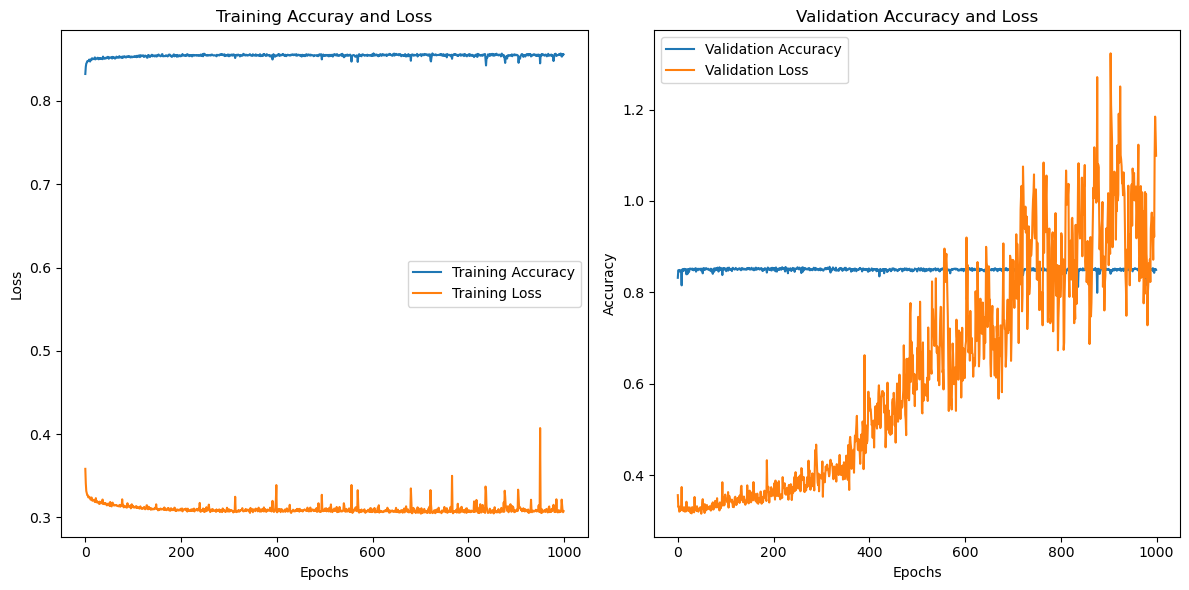

In [104]:
# Plot training loss and Training Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Accuray and Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Validation Loss and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [105]:
y_test_pred = final_ann_model.predict(X_test)
y_test_pred_binary = np.round(y_test_pred)

229/229 [==============================] - 0s 401us/step


#### **Model Evaluation**

In [106]:
precision_test = precision_score(y_test, y_test_pred_binary)
recall_test = recall_score(y_test, y_test_pred_binary)
accuracy_test = accuracy_score(y_test, y_test_pred_binary)
f1_test = f1_score(y_test, y_test_pred_binary)
roc_auc_test = roc_auc_score(y_test, y_test_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred_binary)
class_accuracy_test = conf_matrix_test.diagonal() / conf_matrix_test.sum(axis=1)

In [107]:
# Print the test set metrics
print("Test Set Metrics:")
print("Precision: {:.4f}".format(precision_test))
print("Recall: {:.4f}".format(recall_test))
print("Accuracy: {:.4f}".format(accuracy_test))
print("F1-Score: {:.4f}".format(f1_test))
print("ROC-AUC: {:.4f}".format(roc_auc_test))

Test Set Metrics:
Precision: 0.7986
Recall: 0.5160
Accuracy: 0.8530
F1-Score: 0.6269
ROC-AUC: 0.9020


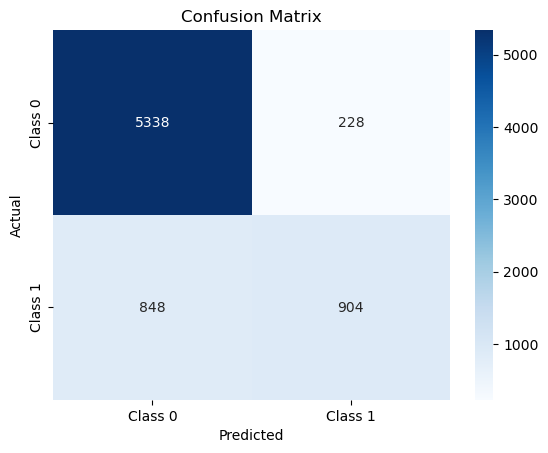

In [108]:
# Calculate confusion matrix to get class-based accuracy
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_labels = ['Class 0', 'Class 1']

# Create a Seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Add labels, title, and axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [109]:
print("Class-Based Accuracy:")
for i, acc in enumerate(class_accuracy):
    print(f"Class {i}: {acc:.4f}")

Class-Based Accuracy:
Class 0: 0.9590
Class 1: 0.5160




### **From Scratch Implementation**

#### **Activation Functions**

In [110]:
'''
Parameters:
    - x: Numerical input (scalar, vector, or matrix) for the sigmoid function.

Returns:
    - Sigmoid of the input, with the same shape as x. The sigmoid function outputs values between 0 and 1.

'''
def sigmoid(x):
    # Apply the sigmoid function: 1 / (1 + exp(-x)).
    sig = 1 / (1 + np.exp(-x))
    return sig

In [111]:
'''
Parameters:
    - x: Output from the sigmoid function (scalar, vector, or matrix).

Returns:
    - Derivative of the sigmoid function at x, with the same shape as x.

'''
def sigmoid_derivative(x):
    # Calculate the derivative of the sigmoid function: x * (1 - x).
    dSig = x * (1 - x)
    return dSig

#### **Loss Function**

In [112]:
'''
Parameters:
    - y_true: True binary labels (0 or 1).
    - y_pred: Predicted probabilities, output of a model.

Returns:
    - Binary cross-entropy loss, a measure of the error between predicted probabilities and true labels.

'''
def binary_crossentropy(y_true, y_pred):
    # Small constant to avoid numerical issues with log(0).
    epsilon = 1e-15

    # Clip predictions to be within the range [epsilon, 1 - epsilon] to ensure numerical stability.
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # Calculate the binary cross-entropy loss.
    return -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

In [113]:
'''
Parameters:
    - y_true: True binary labels (0 or 1).
    - y_pred: Predicted probabilities, output of a model.

Returns:
    - Derivative of the binary cross-entropy loss with respect to the predicted probabilities.

'''
def binary_crossentropy_derivative(y_true, y_pred):
    # Small constant to avoid numerical issues with division and log(0).
    epsilon = 1e-15

    # Clip predictions to be within the range [epsilon, 1 - epsilon] for numerical stability.
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # Calculate the derivative of the binary cross-entropy loss.
    return (y_pred - y_true) / (y_pred * (1 - y_pred))

#### **Initialize Weights**

In [114]:
'''
Parameters:
    - input_size: Size of the input layer (number of input neurons).
    - output_size: Size of the output layer (number of output neurons).
    - initialization: Method for weight initialization. Options are 'he', 'lecun', 'xavier', and 'random'.

Returns:
    - Initialized weights matrix of shape (input_size, output_size) based on the specified method.

Raises:
    - ValueError: If the 'initialization' parameter is not one of the specified methods.

'''
def initialize_weights(input_size, output_size, initialization='he'):
    # He initialization: Scales weights with sqrt(2 / input_size).
    if initialization == 'he':
        return np.random.randn(input_size, output_size) * np.sqrt(2 / input_size)

    # LeCun initialization: Scales weights with sqrt(1 / input_size).
    elif initialization == 'lecun':
        return np.random.randn(input_size, output_size) * np.sqrt(1 / input_size)

    # Xavier initialization: Scales weights with sqrt(1 / (input_size + output_size)).
    elif initialization == 'xavier':
        return np.random.randn(input_size, output_size) * np.sqrt(1 / (input_size + output_size))

    # Random initialization: Weights initialized randomly without scaling.
    elif initialization == 'random':
        return np.random.randn(input_size, output_size)

    # Error handling for invalid initialization method.
    else:
        raise ValueError("Invalid weight initialization")

#### **Adam Optimizer**

In [115]:
class AdamOptimizer:
    '''
    Adam optimizer for updating neural network weights.

    Parameters:
        - learning_rate: Step size for parameter updates. Default is 0.001.
        - beta1: Exponential decay rate for the first moment estimates. Default is 0.9.
        - beta2: Exponential decay rate for the second moment estimates. Default is 0.999.
        - epsilon: Small constant for numerical stability. Default is 1e-8.
    '''
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        # Initialize optimizer parameters and internal state.
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}  # First moment vector.
        self.v = {}  # Second moment vector.
        self.t = 0   # Time step.

    '''
    Update the parameters using the Adam optimization algorithm.

    Parameters:
        - param: Current value of the parameter to be updated.
        - gradient: Gradient of the loss function with respect to the parameter.
        - param_name: Name of the parameter (used for storing moment vectors).

    Returns:
        - Updated parameter.
    '''
    def update(self, param, gradient, param_name):
        # Initialize moment vectors if they don't exist for the parameter.
        if param_name not in self.m:
            self.m[param_name] = np.zeros_like(param)
            self.v[param_name] = np.zeros_like(param)

        # Update time step.
        self.t += 1

        # Update biased first and second moment estimates.
        self.m[param_name] = self.beta1 * self.m[param_name] + (1 - self.beta1) * gradient
        self.v[param_name] = self.beta2 * self.v[param_name] + (1 - self.beta2) * (gradient ** 2)

        # Correct bias in first and second moments.
        m_hat = self.m[param_name] / (1 - self.beta1 ** self.t)
        v_hat = self.v[param_name] / (1 - self.beta2 ** self.t)

        # Compute parameter update.
        update = self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

        return param - update

#### **RMSprop Optimizer**

In [116]:
class RMSpropOptimizer:
    '''
    RMSprop optimizer for updating neural network weights.

    Parameters:
        - learning_rate: Step size for parameter updates. Default is 0.001.
        - decay_rate: Decay rate for the moving average of squared gradients. Default is 0.9.
        - epsilon: Small constant for numerical stability. Default is 1e-8.
    '''
    def __init__(self, learning_rate=0.001, decay_rate=0.9, epsilon=1e-8):
        # Initialize optimizer parameters and internal state.
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        self.accumulated_square = None  # Accumulated square of gradients.

    '''
    Update the parameters using the RMSprop optimization algorithm.

    Parameters:
        - param: Current value of the parameter to be updated.
        - gradient: Gradient of the loss function with respect to the parameter.

    Returns:
        - Updated parameter.
    '''
    def update(self, param, gradient):
        # Initialize accumulated square if it's the first update.
        if self.accumulated_square is None:
            self.accumulated_square = np.zeros_like(param)

        # Update the accumulated square of gradients.
        self.accumulated_square = self.decay_rate * self.accumulated_square + (1 - self.decay_rate) * gradient**2

        # Compute parameter update.
        update = self.learning_rate * gradient / (np.sqrt(self.accumulated_square) + self.epsilon)

        return param - update

#### **Custom Neural Network Class**

In [117]:
class CustomNeuralNetwork:

    def __init__(self, input_size, hidden_units, output_size, learning_rate, initialization='he'):
        '''
        Initialize the CustomNeuralNetwork.

        Parameters:
            - input_size: Number of input features.
            - hidden_units: Number of neurons in the hidden layer.
            - output_size: Number of output neurons (usually 1 for binary classification).
            - learning_rate: Learning rate for the optimizer.
            - initialization: Method for weight initialization. Options: 'he', 'lecun', 'xavier', 'random'.
        '''
        # Set network architecture parameters.
        self.input_size = input_size
        self.hidden_units = hidden_units
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.initialization = initialization

        # Initialize weights for input-to-hidden and hidden-to-output layers.
        self.weights_input_hidden = initialize_weights(self.input_size, self.hidden_units, initialization)
        self.bias_input_hidden = np.zeros((1, self.hidden_units))
#         print("Init weights_input_hidden Shape:", self.weights_input_hidden.shape)

        self.weights_hidden_output = initialize_weights(self.hidden_units, self.output_size, initialization)
        self.bias_hidden_output = np.zeros((1, self.output_size))
#         print("Init weights_hidden_output Shape:", self.weights_hidden_output.shape)

    def forward(self, X):
        '''
        Perform the forward pass through the network.

        Parameters:
            - X: Input data (features).

        Returns:
            - Predictions from the network as probabilities.
        '''
        # print("Forward X_train Shape:", X.shape)
        # print("Forward weights_input_hidden Shape:", self.weights_input_hidden.shape)
        # print("Forward weights_hidden_output Shape:", self.weights_hidden_output.shape)

        # Calculate the input and output of the hidden layer.
        self.hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_input_hidden
        self.hidden_output = sigmoid(self.hidden_input)
        # print("Forward hidden_output Shape:", self.hidden_output.shape)

        # Calculate the input and output of the final layer.
        self.final_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_hidden_output
        self.predictions = sigmoid(self.final_input)

        # Flatten the predictions to ensure a one-dimensional array.
        self.predictions = self.predictions.flatten()
        # print("Forward predictions Shape:", self.predictions.shape)

        return self.predictions



    def backward(self, X, y):
        '''
        Perform the backward pass (backpropagation) and update weights.

        Parameters:
            - X: Input data (features).
            - y: True labels for the input data.
        '''
        # print("Backward X_train Shape:", X.shape)
        # print("Backward y_train Shape:", y.shape)

        # Calculate the loss and its derivative.
        loss = binary_crossentropy(y, self.predictions)
        loss_derivative = binary_crossentropy_derivative(y, self.predictions)

        # Backpropagation for the output layer.
        output_delta = loss_derivative * sigmoid_derivative(self.predictions)
        output_delta = output_delta.reshape(-1, 1)
        self.weights_hidden_output = adam_optimizer.update(self.weights_hidden_output, np.dot(self.hidden_output.T, output_delta), 'weights_hidden_output')
        self.bias_hidden_output = adam_optimizer.update(self.bias_hidden_output, np.sum(output_delta, axis=0, keepdims=True), 'bias_hidden_output')

        # print("Backward output_delta Shape:", output_delta.shape)
        # print("Backward weights_hidden_output Shape:", self.weights_hidden_output.shape)
        # print("Backward hidden output sigmoid Shape:", sigmoid_derivative(self.hidden_output).shape)

        # Backpropagation for the hidden layer.
        hidden_delta = np.dot(output_delta, self.weights_hidden_output.T) * sigmoid_derivative(self.hidden_output)
        self.weights_input_hidden = adam_optimizer.update(self.weights_input_hidden, np.dot(X.T, hidden_delta), 'weights_input_hidden')
        self.bias_input_hidden = adam_optimizer.update(self.bias_input_hidden, np.sum(hidden_delta, axis=0, keepdims=True), 'bias_input_hidden')

    def compile_net(self, optimizer='adam', loss='binary_crossentropy'):
        '''
        Compile the neural network with specified optimizer and loss function.

        Parameters:
            - optimizer: Name of the optimizer to use. Default is 'adam'.
            - loss: Name of the loss function to use. Default is 'binary_crossentropy'.
        '''
        # Define optimizers globally for access in train and predict functions.
        global adam_optimizer, rmsprop_optimizer

        # Initialize the Adam optimizer.
        adam_optimizer = AdamOptimizer(learning_rate=self.learning_rate)

        # Initialize the RMSprop optimizer.
        rmsprop_optimizer = RMSpropOptimizer(learning_rate=self.learning_rate)

        # Set the loss function based on the provided dictionary.
        self.loss_function = loss_function_dict[loss]

    def train(self, X_train, y_train, X_val, y_val, epochs=500):
        '''
        Train the neural network.

        Parameters:
            - X_train: Training data.
            - y_train: Training labels.
            - X_val: Validation data.
            - y_val: Validation labels.
            - epochs: Number of training epochs. Default is 500.

        Returns:
            - Lists of training and validation losses and accuracies per epoch.
        '''
        # Convert labels from Pandas Series to NumPy arrays if necessary.
        y_train = y_train.values if isinstance(y_train, pd.Series) else y_train
        y_val = y_val.values if isinstance(y_val, pd.Series) else y_val

        # Initialize lists to store loss and accuracy metrics.
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(1, epochs + 1):
            # Perform forward and backward passes on training data.
            predictions_train = self.forward(X_train)
            self.backward(X_train, y_train)

            # Perform forward pass on validation data.
            predictions_val = self.forward(X_val)

            # Compute and store training and validation metrics.
            train_loss = np.mean(self.loss_function(y_train, predictions_train))
            val_loss = np.mean(self.loss_function(y_val, predictions_val))
            train_acc = np.mean((predictions_train > 0.5) == y_train)
            val_acc = np.mean((predictions_val > 0.5) == y_val)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            # Print metrics at specified intervals.
            if epoch == 1 or epoch % 100 == 0 or epoch == epochs:
                print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        return train_losses, val_losses, train_accuracies, val_accuracies


    def predict(self, X):
        '''
        Make predictions on new data using the trained neural network.

        Parameters:
            - X: Input data for prediction.

        Returns:
            - Binary predictions (0 or 1) for the input data.
        '''
        # Perform a forward pass to get the output probabilities.
        self.hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_input_hidden
        self.hidden_output = sigmoid(self.hidden_input)
        self.final_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_hidden_output
        predictions = sigmoid(self.final_input)

        # Convert the output probabilities to binary predictions.
        binary_predictions = (predictions > 0.5).astype(int)

        # Flatten the binary predictions to ensure a one-dimensional output.
        return binary_predictions.flatten()

#### **Model Performance**

In [118]:
'''
Calculate various performance metrics based on true and predicted labels.

Parameters:
    - y_true: True labels.
    - y_pred: Predicted labels.

Returns:
    - accuracy: Accuracy of predictions.
    - precision: Precision score.
    - recall: Recall score.
    - f1_score: F1-score.
    - class_acc: Class-based accuracy.
    - cm: Confusion matrix.
'''
def calculate_metrics(y_true, y_pred):
    # Calculate the confusion matrix.
    cm = confusion_matrix(y_true, y_pred)

    # Calculate class-based accuracy.
    class_acc = cm.diagonal() / np.sum(cm, axis=1)

    # Calculate accuracy, precision, recall, and F1-score.
    true_positive = cm[1, 1]
    false_positive = cm[0, 1]
    false_negative = cm[1, 0]
    true_negative = cm[0, 0]

    accuracy = (true_positive + true_negative) / np.sum(cm)
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return accuracy, precision, recall, f1_score, class_acc, cm

#### **Model Training**

In [119]:
# Define a dictionary to map loss function names to their implementations
loss_function_dict = {
    'binary_crossentropy': binary_crossentropy
}

In [120]:
# Define a dictionary of hyperparameters for a neural network
hyperparameters = best_hps.values

# Print the hyperparameters to the console
print(hyperparameters)

{'hidden_layers': 2, 'units_0': 224, 'learning_rate': 0.01, 'units_1': 64, 'units_2': 192, 'units_3': 32}


In [121]:
# Determine the input size based on the number of features in the training data
input_size = X_train.shape[1]

# Retrieve the number of hidden units for the first hidden layer from the hyperparameters dictionary
hidden_units = hyperparameters['units_1']

# Set the output size to 1, indicating a binary classification problem
output_size = 1

# Retrieve the learning rate from the hyperparameters dictionary
learning_rate = hyperparameters['learning_rate']

# Define the number of training epochs for the neural network
epochs = 1000

In [122]:
# Create an instance of the CustomNeuralNetwork class with specified parameters
model = CustomNeuralNetwork(input_size, hidden_units, output_size, learning_rate)

# Compile the neural network by specifying the optimizer and loss function
model.compile_net(optimizer='adam', loss='binary_crossentropy')

In [123]:
# Train the neural network and collect training and validation metrics
train_losses, val_losses, train_accuracies, val_accuracies = model.train(X_train, y_train, X_val, y_val, epochs=epochs)

Epoch 1, Train Loss: 0.6168, Train Acc: 0.7653, Val Loss: 0.5535, Val Acc: 0.7620
Epoch 100, Train Loss: 0.3263, Train Acc: 0.8470, Val Loss: 0.3243, Val Acc: 0.8456
Epoch 200, Train Loss: 0.3166, Train Acc: 0.8514, Val Loss: 0.3165, Val Acc: 0.8503
Epoch 300, Train Loss: 0.3133, Train Acc: 0.8526, Val Loss: 0.3142, Val Acc: 0.8507
Epoch 400, Train Loss: 0.3108, Train Acc: 0.8540, Val Loss: 0.3121, Val Acc: 0.8508
Epoch 500, Train Loss: 0.3089, Train Acc: 0.8551, Val Loss: 0.3108, Val Acc: 0.8513
Epoch 600, Train Loss: 0.3075, Train Acc: 0.8557, Val Loss: 0.3105, Val Acc: 0.8533
Epoch 700, Train Loss: 0.3056, Train Acc: 0.8561, Val Loss: 0.3097, Val Acc: 0.8524
Epoch 800, Train Loss: 0.3046, Train Acc: 0.8566, Val Loss: 0.3091, Val Acc: 0.8524
Epoch 900, Train Loss: 0.3037, Train Acc: 0.8567, Val Loss: 0.3090, Val Acc: 0.8518
Epoch 1000, Train Loss: 0.3029, Train Acc: 0.8574, Val Loss: 0.3091, Val Acc: 0.8516


In [124]:
# Use the trained neural network to make predictions on test data
y_pred = model.predict(X_test)

# Print the shape of the predicted values
print(f'y_pred Shape: {y_pred.shape}')

y_pred Shape: (7318,)


In [125]:
# Calculate various performance metrics based on predicted and true labels
accuracy, precision, recall, f1_score, class_acc, cm = calculate_metrics(y_test, y_pred)

In [126]:
# Print evaluation metrics as needed
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Class-based Accuracy:", class_acc)
print("Confusion Matrix:\n", cm)

Accuracy: 0.8522820442743919
Precision: 0.7422382671480144
Recall: 0.58675799086758
F1 Score: 0.6554032515141857
Class-based Accuracy: [0.93586058 0.58675799]
Confusion Matrix:
 [[5209  357]
 [ 724 1028]]


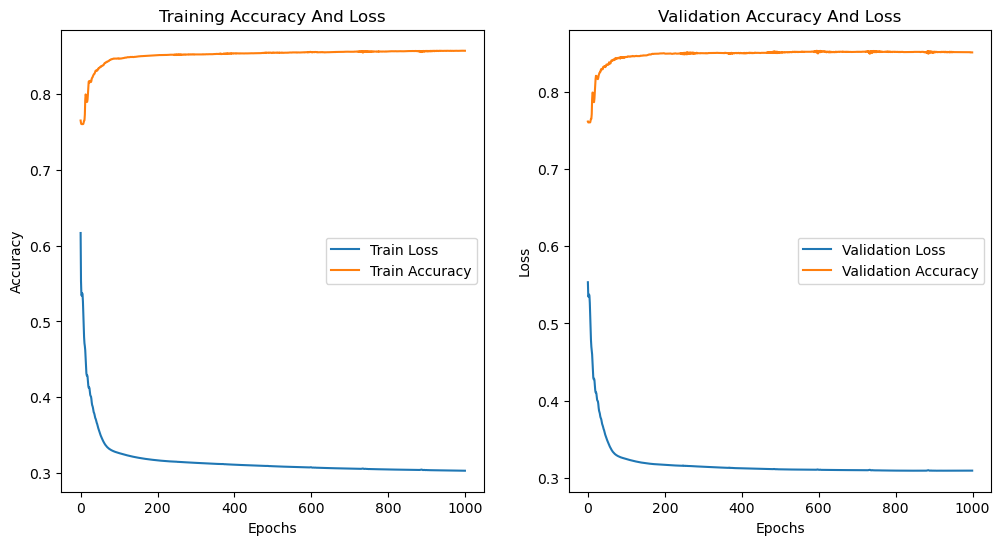

In [135]:
# Plot Accuracy and Loss graphs
plt.figure(figsize=(12, 6))

# Plot training accuracy and loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Training Accuracy And Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation accuracy and loss
plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy And Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### **K-Fold Cross Validation**

In [128]:
'''
Perform k-fold cross-validation on a custom neural network model.

Parameters:
    - X: Input data for cross-validation.
    - y: True class labels for cross-validation.
    - k: Number of folds for cross-validation.
    - hyperparameters: A dictionary containing hyperparameters for the neural network.
    - initialization: Weight initialization method.

Returns:
    - avg_metrics: A list of average evaluation metrics across all folds.
        - Average accuracy.
        - Average precision.
        - Average recall.
        - Average F1-score.
        - Average class-based accuracies.
        - Average confusion matrix.
'''
def k_fold_cross_validation(X, y, k, hyperparameters, initialization):
    # Convert X and y to numpy arrays if they are pandas dataframes/series.
    X = X.values if isinstance(X, pd.DataFrame) else X
    y = y.values if isinstance(y, pd.Series) else y

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    accuracies, precisions, recalls, f1_scores, class_accs, cms = [], [], [], [], [], []

    for train_index, val_index in skf.split(X, y):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Create a new instance of the model
        model = CustomNeuralNetwork(X_train_fold.shape[1],
                                    hyperparameters['units_1'],
                                    1,
                                    hyperparameters['learning_rate'],
                                    initialization)

        # Compile and train the model
        model.compile_net(optimizer='adam', loss='binary_crossentropy')
        model.train(X_train_fold, y_train_fold, X_val_fold, y_val_fold, epochs=1000)

        # Predict and evaluate
        y_pred = model.predict(X_val_fold)
        accuracy, precision, recall, f1_score, class_acc, cm = calculate_metrics(y_val_fold, y_pred)

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
        class_accs.append(class_acc)
        cms.append(cm)

    # Calculate the average of the metrics
    avg_metrics = [np.mean(accuracies), np.mean(precisions), np.mean(recalls),
                   np.mean(f1_scores), np.mean(class_accs), np.mean(cms, axis=0)]

    return avg_metrics

In [129]:
avg_metrics = k_fold_cross_validation(X_train, y_train, k=10, hyperparameters=hyperparameters, initialization='he')

Epoch 1, Train Loss: 0.6019, Train Acc: 0.7605, Val Loss: 0.5556, Val Acc: 0.7605
Epoch 100, Train Loss: 0.3235, Train Acc: 0.8480, Val Loss: 0.3349, Val Acc: 0.8457
Epoch 200, Train Loss: 0.3165, Train Acc: 0.8519, Val Loss: 0.3289, Val Acc: 0.8454
Epoch 300, Train Loss: 0.3136, Train Acc: 0.8532, Val Loss: 0.3266, Val Acc: 0.8478
Epoch 400, Train Loss: 0.3109, Train Acc: 0.8541, Val Loss: 0.3245, Val Acc: 0.8478
Epoch 500, Train Loss: 0.3079, Train Acc: 0.8558, Val Loss: 0.3228, Val Acc: 0.8489
Epoch 600, Train Loss: 0.3056, Train Acc: 0.8567, Val Loss: 0.3221, Val Acc: 0.8478
Epoch 700, Train Loss: 0.3036, Train Acc: 0.8572, Val Loss: 0.3226, Val Acc: 0.8475
Epoch 800, Train Loss: 0.3020, Train Acc: 0.8576, Val Loss: 0.3241, Val Acc: 0.8463
Epoch 900, Train Loss: 0.3008, Train Acc: 0.8583, Val Loss: 0.3248, Val Acc: 0.8478
Epoch 1000, Train Loss: 0.2997, Train Acc: 0.8593, Val Loss: 0.3253, Val Acc: 0.8481
Epoch 1, Train Loss: 0.9559, Train Acc: 0.2394, Val Loss: 0.8078, Val Acc: 0.

Epoch 1000, Train Loss: 0.3016, Train Acc: 0.8584, Val Loss: 0.3116, Val Acc: 0.8551
Epoch 1, Train Loss: 0.5175, Train Acc: 0.7606, Val Loss: 0.5059, Val Acc: 0.7608
Epoch 100, Train Loss: 0.3210, Train Acc: 0.8479, Val Loss: 0.3143, Val Acc: 0.8586
Epoch 200, Train Loss: 0.3151, Train Acc: 0.8512, Val Loss: 0.3115, Val Acc: 0.8650
Epoch 300, Train Loss: 0.3119, Train Acc: 0.8530, Val Loss: 0.3102, Val Acc: 0.8665
Epoch 400, Train Loss: 0.3089, Train Acc: 0.8540, Val Loss: 0.3086, Val Acc: 0.8671
Epoch 500, Train Loss: 0.3064, Train Acc: 0.8550, Val Loss: 0.3072, Val Acc: 0.8682
Epoch 600, Train Loss: 0.3048, Train Acc: 0.8556, Val Loss: 0.3070, Val Acc: 0.8679
Epoch 700, Train Loss: 0.3035, Train Acc: 0.8561, Val Loss: 0.3070, Val Acc: 0.8671
Epoch 800, Train Loss: 0.3023, Train Acc: 0.8566, Val Loss: 0.3073, Val Acc: 0.8659
Epoch 900, Train Loss: 0.3022, Train Acc: 0.8573, Val Loss: 0.3096, Val Acc: 0.8653
Epoch 1000, Train Loss: 0.3002, Train Acc: 0.8568, Val Loss: 0.3079, Val Acc:

In [130]:
print("Average Metrics over 10 folds:")
print("Accuracy:", avg_metrics[0])
print("Precision:", avg_metrics[1])
print("Recall:", avg_metrics[2])
print("F1 Score:", avg_metrics[3])
print("Class-based Accuracy:", avg_metrics[4])
print("Confusion Matrix:\n", cm)

Average Metrics over 10 folds:
Accuracy: 0.8540101014603572
Precision: 0.753367846671244
Recall: 0.5806561664866094
F1 Score: 0.6556528983849239
Class-based Accuracy: 0.7603579157349314
Confusion Matrix:
 [[5209  357]
 [ 724 1028]]
